## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## Styles

In [2]:
class Styles:
    def __init__(self):
        # Text colors
        self.FG_RED = '\033[0;31m'
        self.FG_GREEN = '\033[0;32m'
        self.FG_YELLOW = '\033[0;33m'
        self.FG_BLUE = '\033[0;34m'
        self.FG_MAGENTA = '\033[0;35m'
        self.FG_CYAN = '\033[0;36m'
        self.FG_WHITE = '\033[0;37m'

        # Background colors
        self.BG_RED = '\033[41m'
        self.BG_GREEN = '\033[42m'
        self.BG_YELLOW = '\033[43m'
        self.BG_BLUE = '\033[44m'
        self.BG_MAGENTA = '\033[45m'
        self.BG_CYAN = '\033[46m'
        self.BG_WHITE = '\033[47m'

        # Text styles
        self.BOLD = '\033[1m'
        self.UNDERLINE = '\033[4m'
        self.BLINK = '\033[5m'
        self.REVERSE = '\033[7m'
        self.HIDDEN = '\033[8m'
        self.RESET = '\033[0m'

styles = Styles()

## General Stats

In [3]:
def print_missing_values(file_path):
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Count rows and missing values
    num_rows = df.shape[0]
    missing_values = df.isnull().sum()
    
    # Print results using PrettyTable
    table = PrettyTable()
    table.field_names = [f"{styles.BOLD}{styles.FG_CYAN}Column{styles.RESET}", f"{styles.BOLD}{styles.FG_YELLOW}Missing Values{styles.RESET}"]
    for index, value in missing_values.items():
        table.add_row([f"{styles.FG_GREEN}{index}{styles.RESET}", value])
    
    print(f"\n{styles.BOLD}{styles.FG_BLUE}Dataset Statistics:{styles.RESET}")
    print(f"Total Rows: {styles.FG_RED}{num_rows}{styles.RESET}")
    print(table)

print_missing_values("sampled_data.csv")


Dataset Statistics:
Total Rows: 8000
+------------------+----------------+
|      Column      | Missing Values |
+------------------+----------------+
|   Campaign_ID    |       0        |
| Target_Audience  |       0        |
|  Campaign_Goal   |       0        |
|     Duration     |       0        |
|   Channel_Used   |       0        |
| Conversion_Rate  |       0        |
| Acquisition_Cost |       0        |
|       ROI        |       0        |
|     Location     |       0        |
|     Language     |       0        |
|      Clicks      |       0        |
|   Impressions    |       0        |
| Engagement_Score |       0        |
| Customer_Segment |       0        |
|       Date       |       0        |
|     Company      |       0        |
+------------------+----------------+


## Descriptive Statistics

In [4]:
def load_and_describe(file_path):
    df = pd.read_csv(file_path)
    
    # Convert relevant columns to numerical values
    df['Conversion_Rate'] = df['Conversion_Rate'].astype(float)
    df['Acquisition_Cost'] = df['Acquisition_Cost'].replace('[\\$,]', '', regex=True).astype(float)
    df['ROI'] = df['ROI'].astype(float)
    df['Clicks'] = df['Clicks'].astype(int)
    df['Impressions'] = df['Impressions'].astype(int)
    df['Engagement_Score'] = df['Engagement_Score'].astype(int)
    
    stats = df.describe().T.round(4)
    table = PrettyTable()
    table.field_names = [f"{styles.BOLD}{styles.FG_CYAN}Feature{styles.RESET}"] + list(stats.columns)
    for index, row in stats.iterrows():
        table.add_row([f"{styles.FG_GREEN}{index}{styles.RESET}"] + list(row))
    print(f"\n{styles.BOLD}{styles.FG_BLUE}Numerical Feature Statistics:{styles.RESET}")
    print(table)
    
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        unique_values = df[col].unique()
        print(f"\n{styles.BOLD}{styles.FG_BLUE}Unique values in {col}:{styles.RESET} {styles.FG_MAGENTA}{', '.join(map(str, unique_values))}{styles.RESET}")
    
    return df

df = load_and_describe('sampled_data.csv')

print("\nFirst 5 rows of the dataset:")
print(df.head())


Numerical Feature Statistics:
+------------------+--------+-------------+------------+----------+-----------+----------+----------+----------+
|     Feature      | count  |     mean    |    std     |   min    |    25%    |   50%    |   75%    |   max    |
+------------------+--------+-------------+------------+----------+-----------+----------+----------+----------+
|   Campaign_ID    | 8000.0 | 550234.1351 | 257829.128 | 100066.0 |  331569.5 | 556482.0 | 770410.0 | 999726.0 |
| Conversion_Rate  | 8000.0 |    0.0798   |   0.0406   |   0.01   |    0.04   |   0.08   |   0.11   |   0.15   |
| Acquisition_Cost | 8000.0 |  7679.2728  | 4313.1303  |  500.0   | 4040.4375 | 7659.945 | 11281.15 | 15000.0  |
|       ROI        | 8000.0 |    3.2091   |   2.4598   |   0.0    |   0.9581  |   2.74   |   5.38   |   8.0    |
|      Clicks      | 8000.0 |  17984.4112 | 11054.6771 |  293.0   |   8542.5  | 17042.5  | 26605.5  | 39989.0  |
|   Impressions    | 8000.0 |  55520.118  | 32671.5823 |  1937.0 

## Histograms

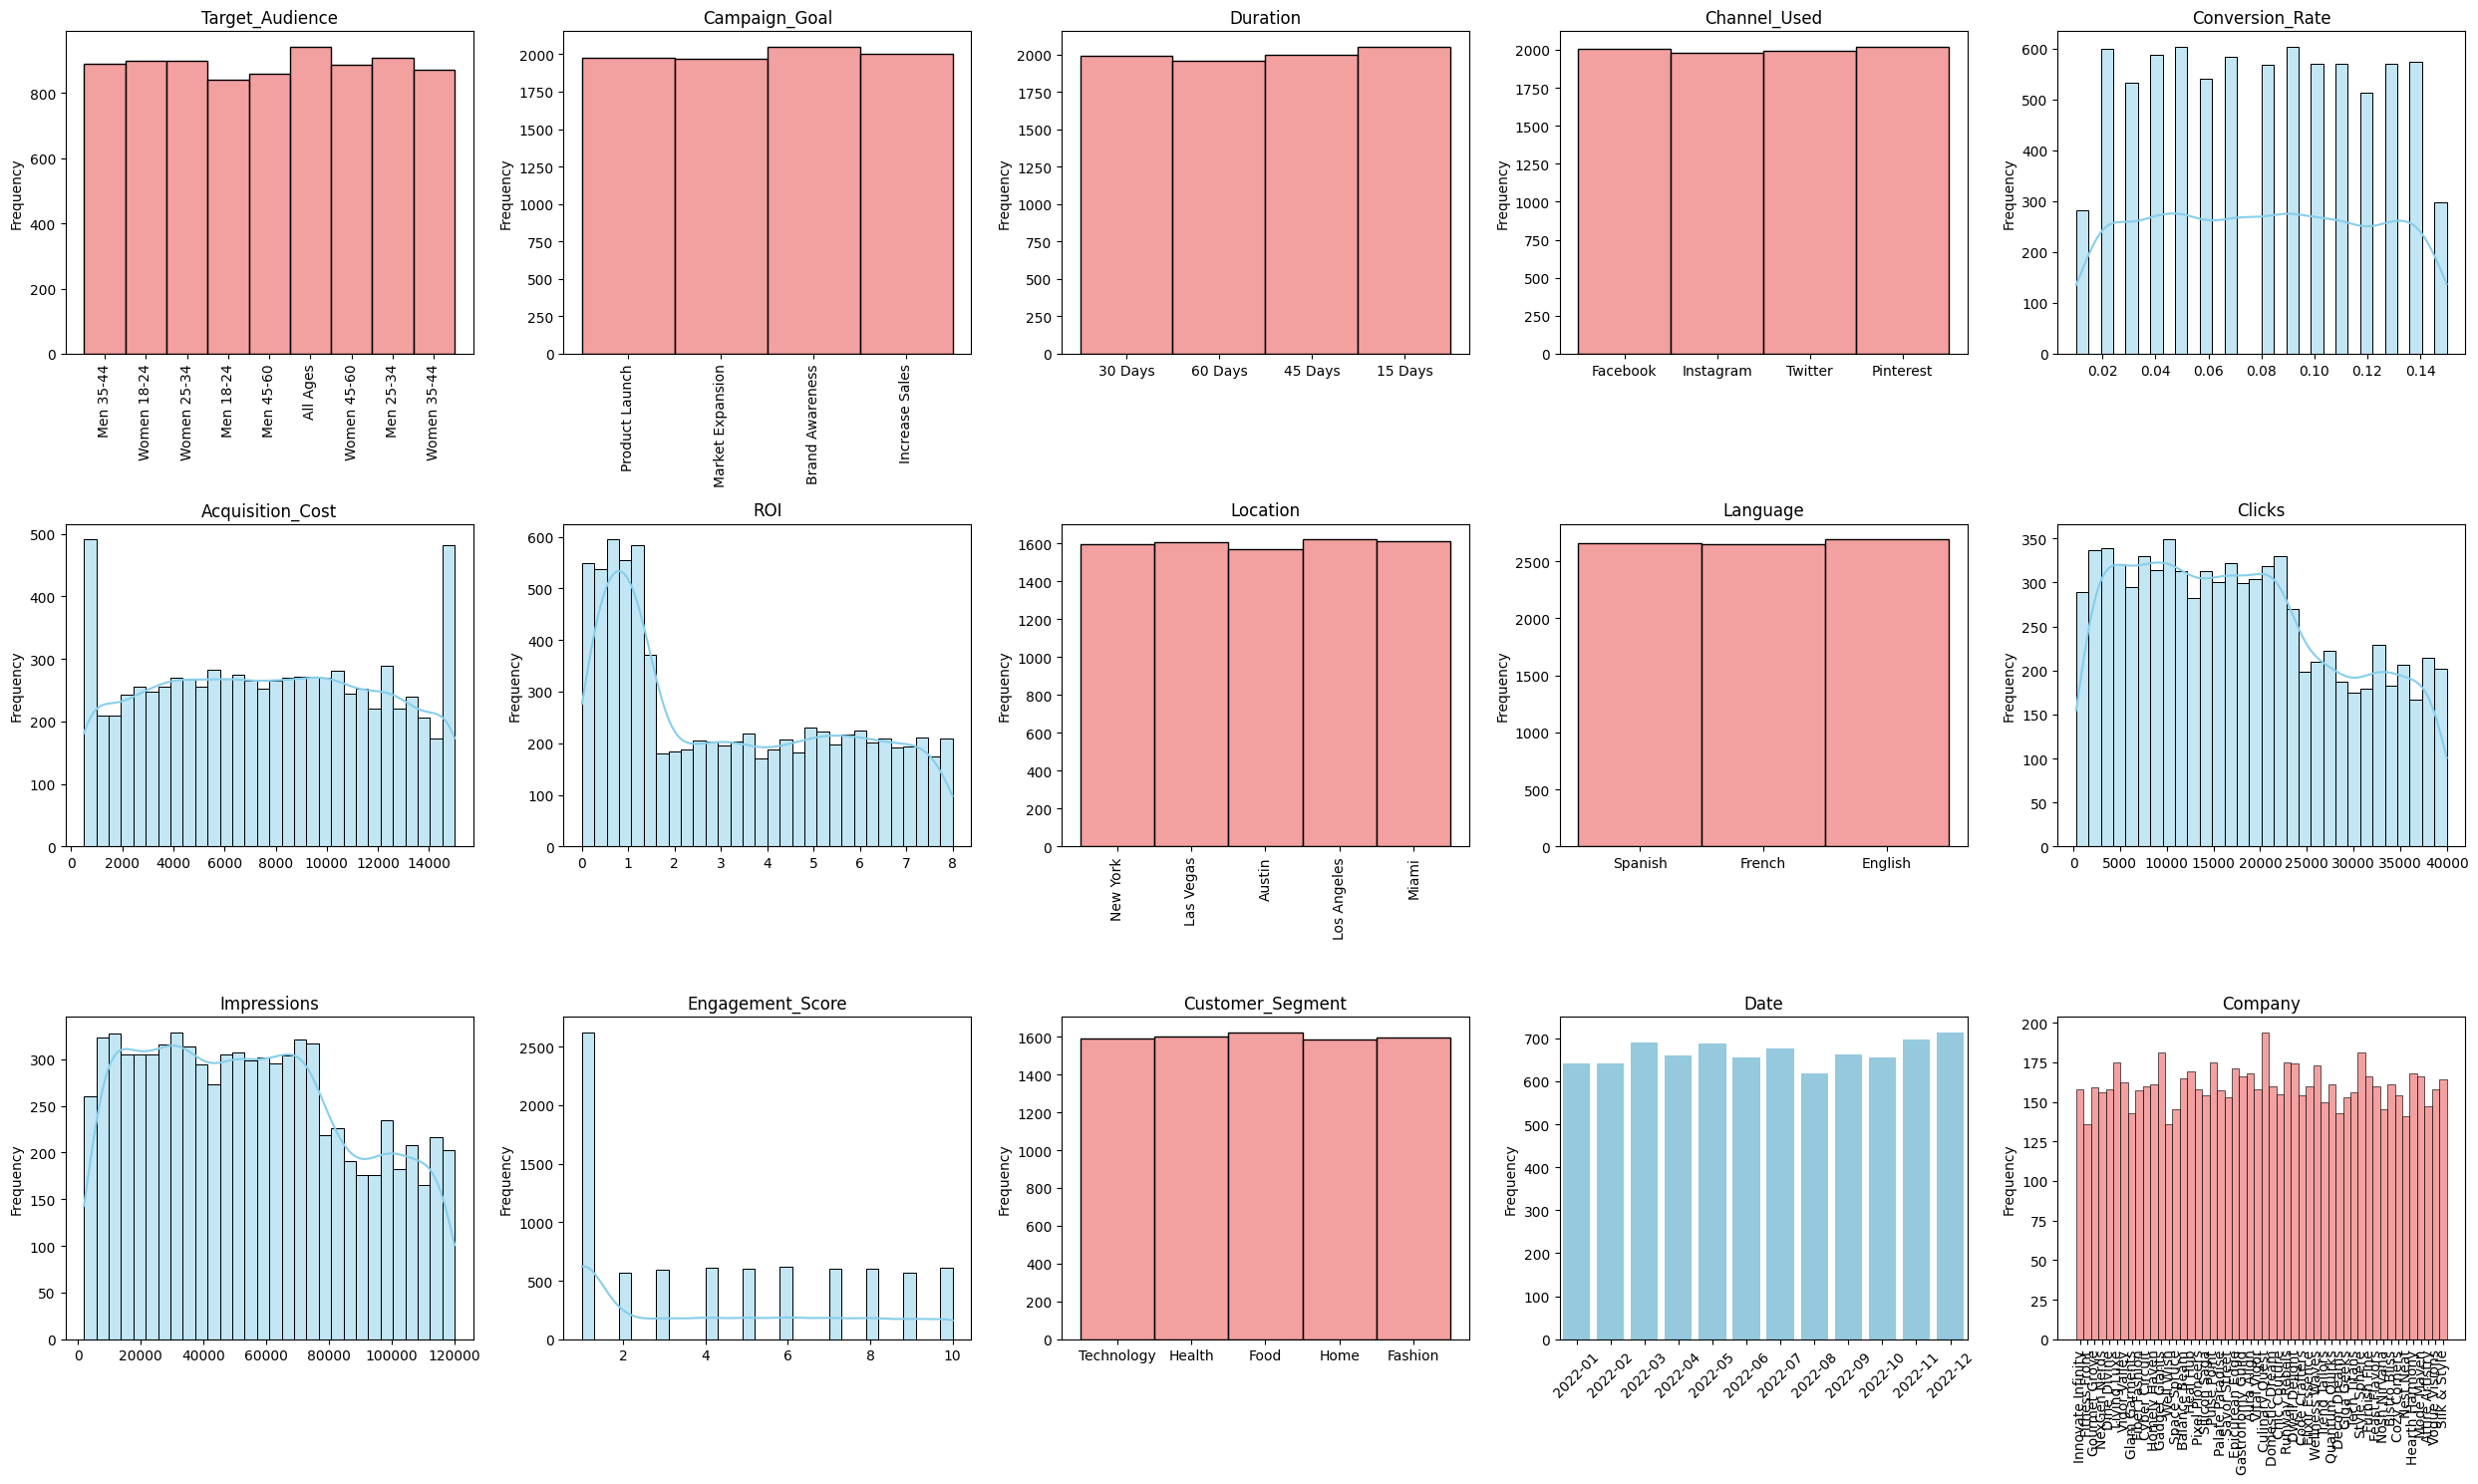

In [5]:
def plot_histograms(df):
    columns = df.columns
    fig, axes = plt.subplots(3, 5, figsize=(25, 15))
    axes = [ax for sublist in axes for ax in sublist]
    
    i = 0
    for col in columns:
        if i >= 15:
            break
        if col == "Campaign_ID":
            continue

        if col == "Date":  # Bar graph for total campaigns per month
            df['Date'] = pd.to_datetime(df['Date'])
            df['Month'] = df['Date'].dt.to_period('M')
            campaign_counts = df['Month'].value_counts().sort_index()
            sns.barplot(x=campaign_counts.index.astype(str), y=campaign_counts.values, ax=axes[i], color='skyblue')
            axes[i].set_title("Total Number of Campaigns Per Month", fontsize=12)
            axes[i].set_xlabel("Month")
            axes[i].set_ylabel("Number of Campaigns")
            axes[i].tick_params(axis='x', rotation=45)
        
        elif df[col].dtype in ['int64', 'float64']:
            sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='skyblue')
        else:
            sns.histplot(df[col], discrete=True, stat="count", ax=axes[i], color='lightcoral')
            if col in ['Target_Audience', 'Campaign_Goal', 'Location', 'Company']:
                axes[i].tick_params(axis='x', rotation=90)
        
        axes[i].set_title(col, fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Frequency')
        i += 1
    
    # Hide unused subplots
    for j in range(i, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('histograms.png', dpi=300)
    plt.show()

plot_histograms(df)

## Box and Violin Plots

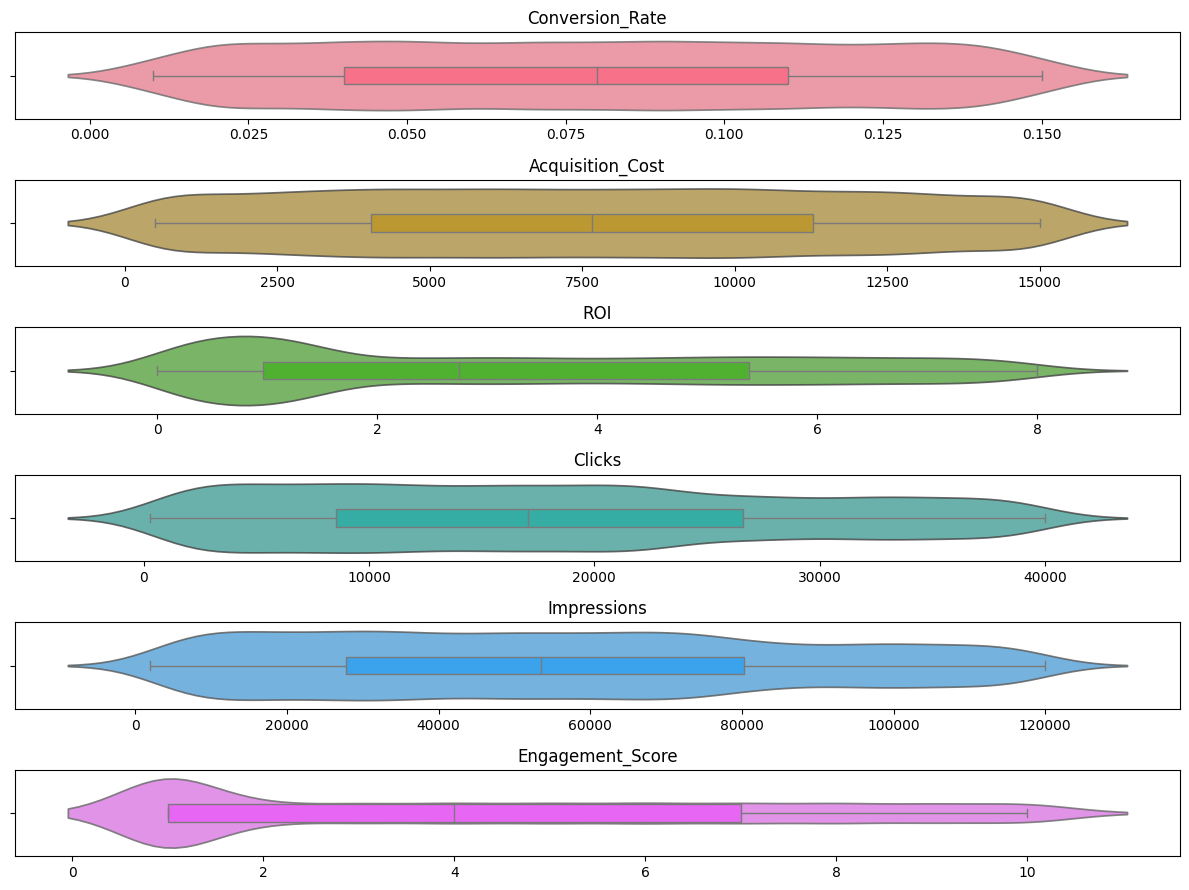

In [6]:
def plot_violin_with_box(df):
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if 'Campaign_ID' in numerical_cols:
        numerical_cols = numerical_cols.drop('Campaign_ID')

    colors = sns.color_palette("husl", len(numerical_cols))  # Generate unique colors

    plt.figure(figsize=(12, len(numerical_cols) * 1.5))
    sns.set_palette("pastel")

    for i, (col, color) in enumerate(zip(numerical_cols, colors)):
        plt.subplot(len(numerical_cols), 1, i + 1)
        sns.violinplot(x=df[col], inner=None, color=color, alpha=0.8)
        sns.boxplot(x=df[col], width=0.2, boxprops={'zorder': 2, 'facecolor': color})
        plt.title(col, fontsize=12)
        plt.xlabel('')

    plt.tight_layout()
    plt.savefig('violin_box_plots.png', dpi=300)
    plt.show()

plot_violin_with_box(df)


## Q-Q plots

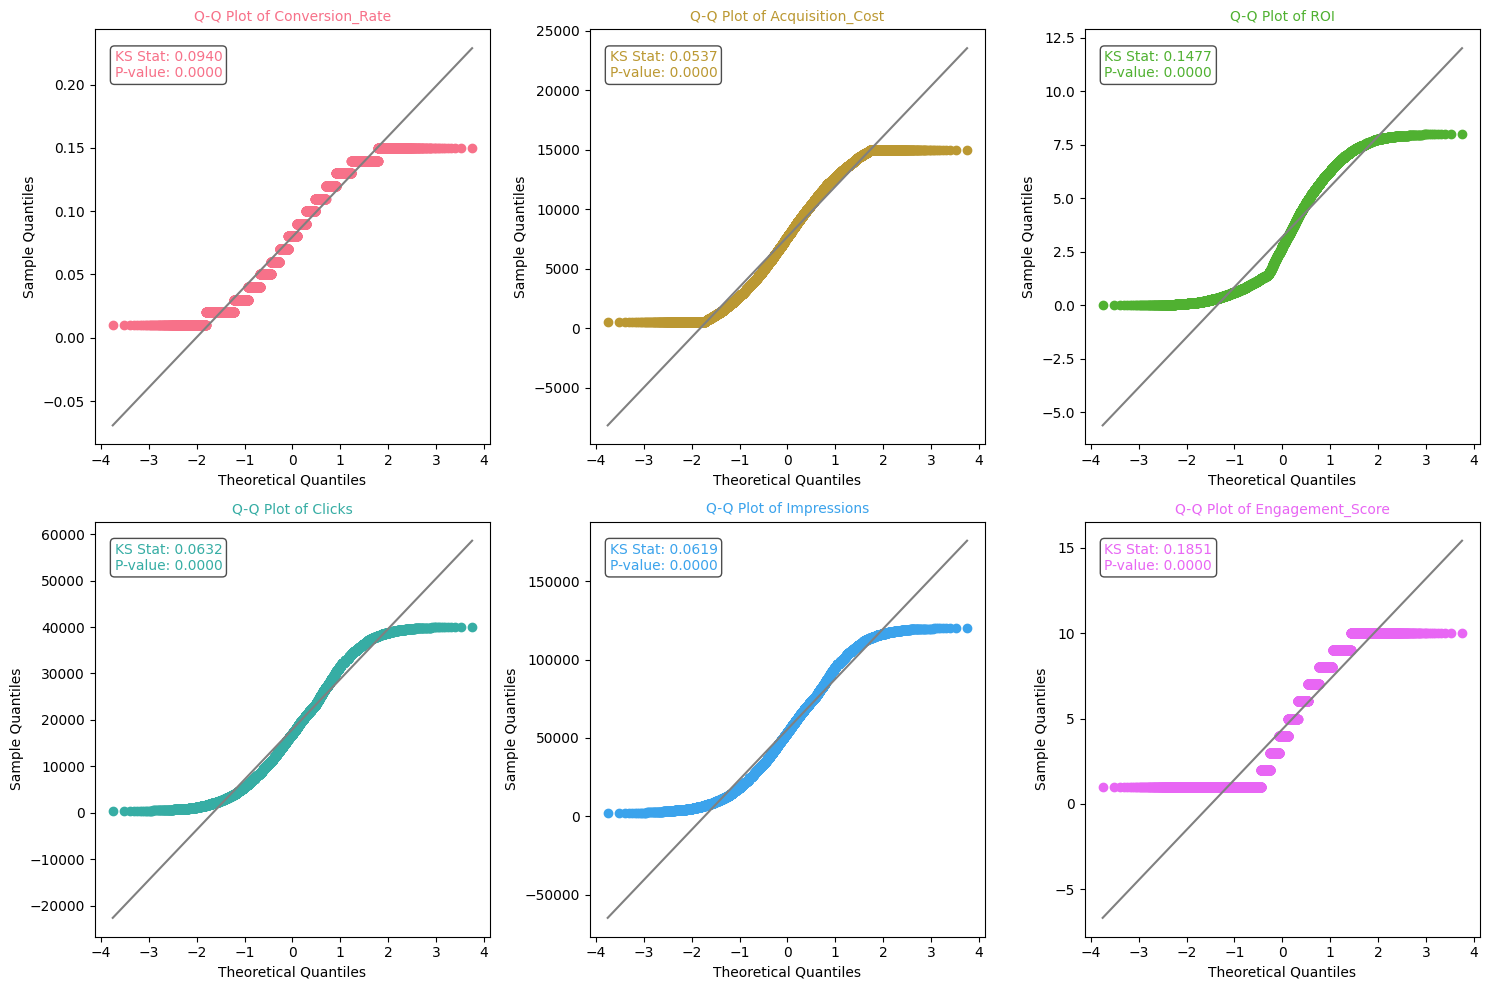

In [7]:
def plot_qq_plots(df):
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if 'Campaign_ID' in numerical_cols:
        numerical_cols = numerical_cols.drop('Campaign_ID')

    num_plots = len(numerical_cols)
    num_cols = (num_plots + 1) // 2  # Determine the number of rows for subplots
    colors = sns.color_palette("husl", num_plots)

    fig, axes = plt.subplots(2, num_cols, figsize=(5 * num_cols, 10))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, (col, color) in enumerate(zip(numerical_cols, colors)):
        col_data = df[col].dropna()
        stats.probplot(col_data, dist="norm", plot=axes[i])

        col_mean = np.mean(col_data)
        col_std = np.std(col_data, ddof=1)
        standardized_data = (col_data - col_mean) / col_std
        ks_stat, p_value = stats.kstest(standardized_data, 'norm')

        axes[i].set_title(f"Q-Q Plot of {col}", fontsize=10, color=color)
        axes[i].set_xlabel("Theoretical Quantiles")
        axes[i].set_ylabel("Sample Quantiles")
        axes[i].get_lines()[0].set_color(color)  # Color the scatter plot points
        axes[i].get_lines()[1].set_color('gray') # Color the reference line

        # Add KS test results inside the plot with the same color
        text_str = f"KS Stat: {ks_stat:.4f}\nP-value: {p_value:.4f}"
        axes[i].text(0.05, 0.95, text_str, transform=axes[i].transAxes,
                     verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
                     color=color)

    # Remove any unused subplots if the number of columns is odd
    if num_plots % 2 != 0:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.savefig('qq_plots.png', dpi=300)
    plt.show()

plot_qq_plots(df)

## Correlation Matrix

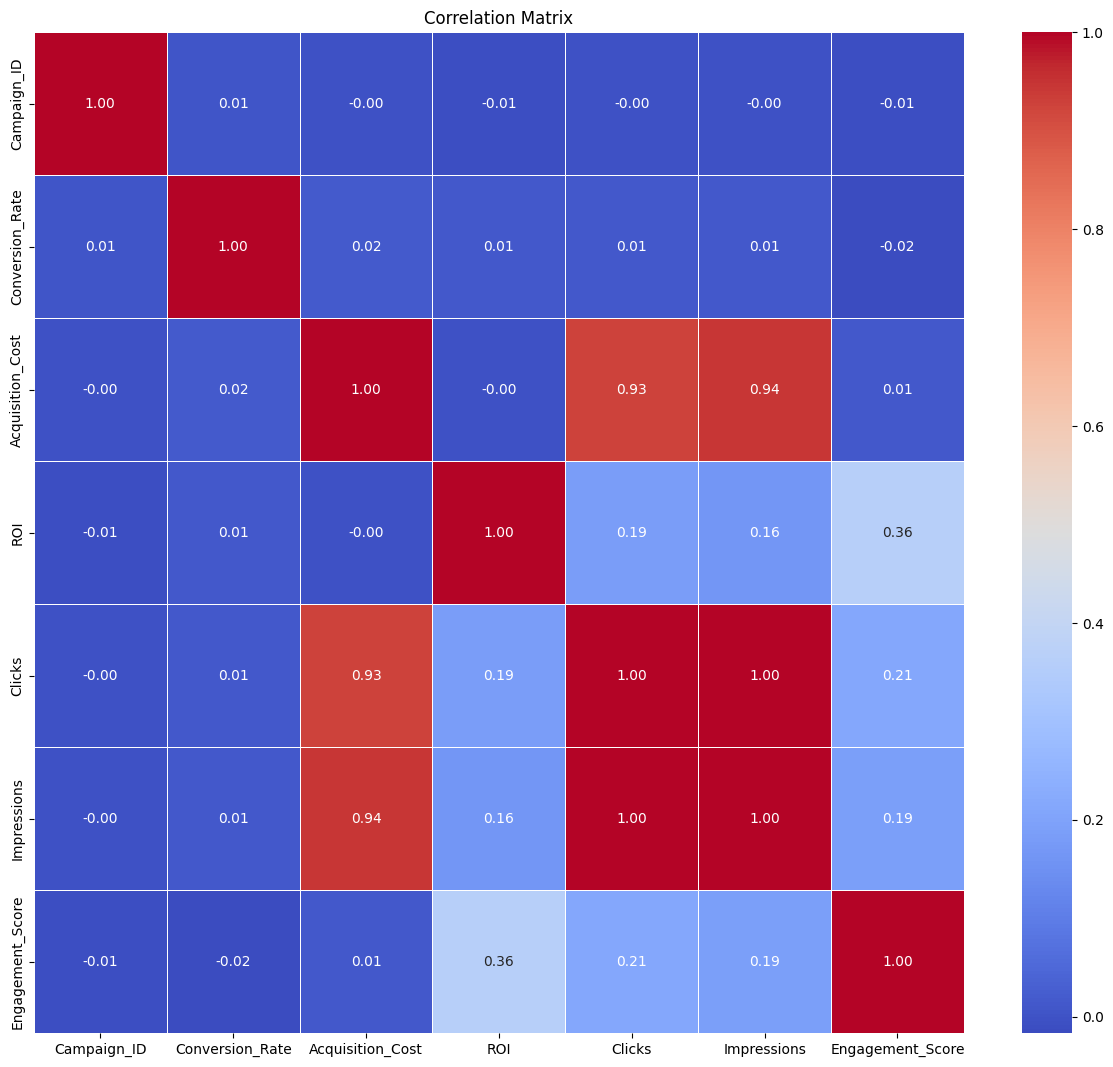

In [8]:
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

## Pair Plot

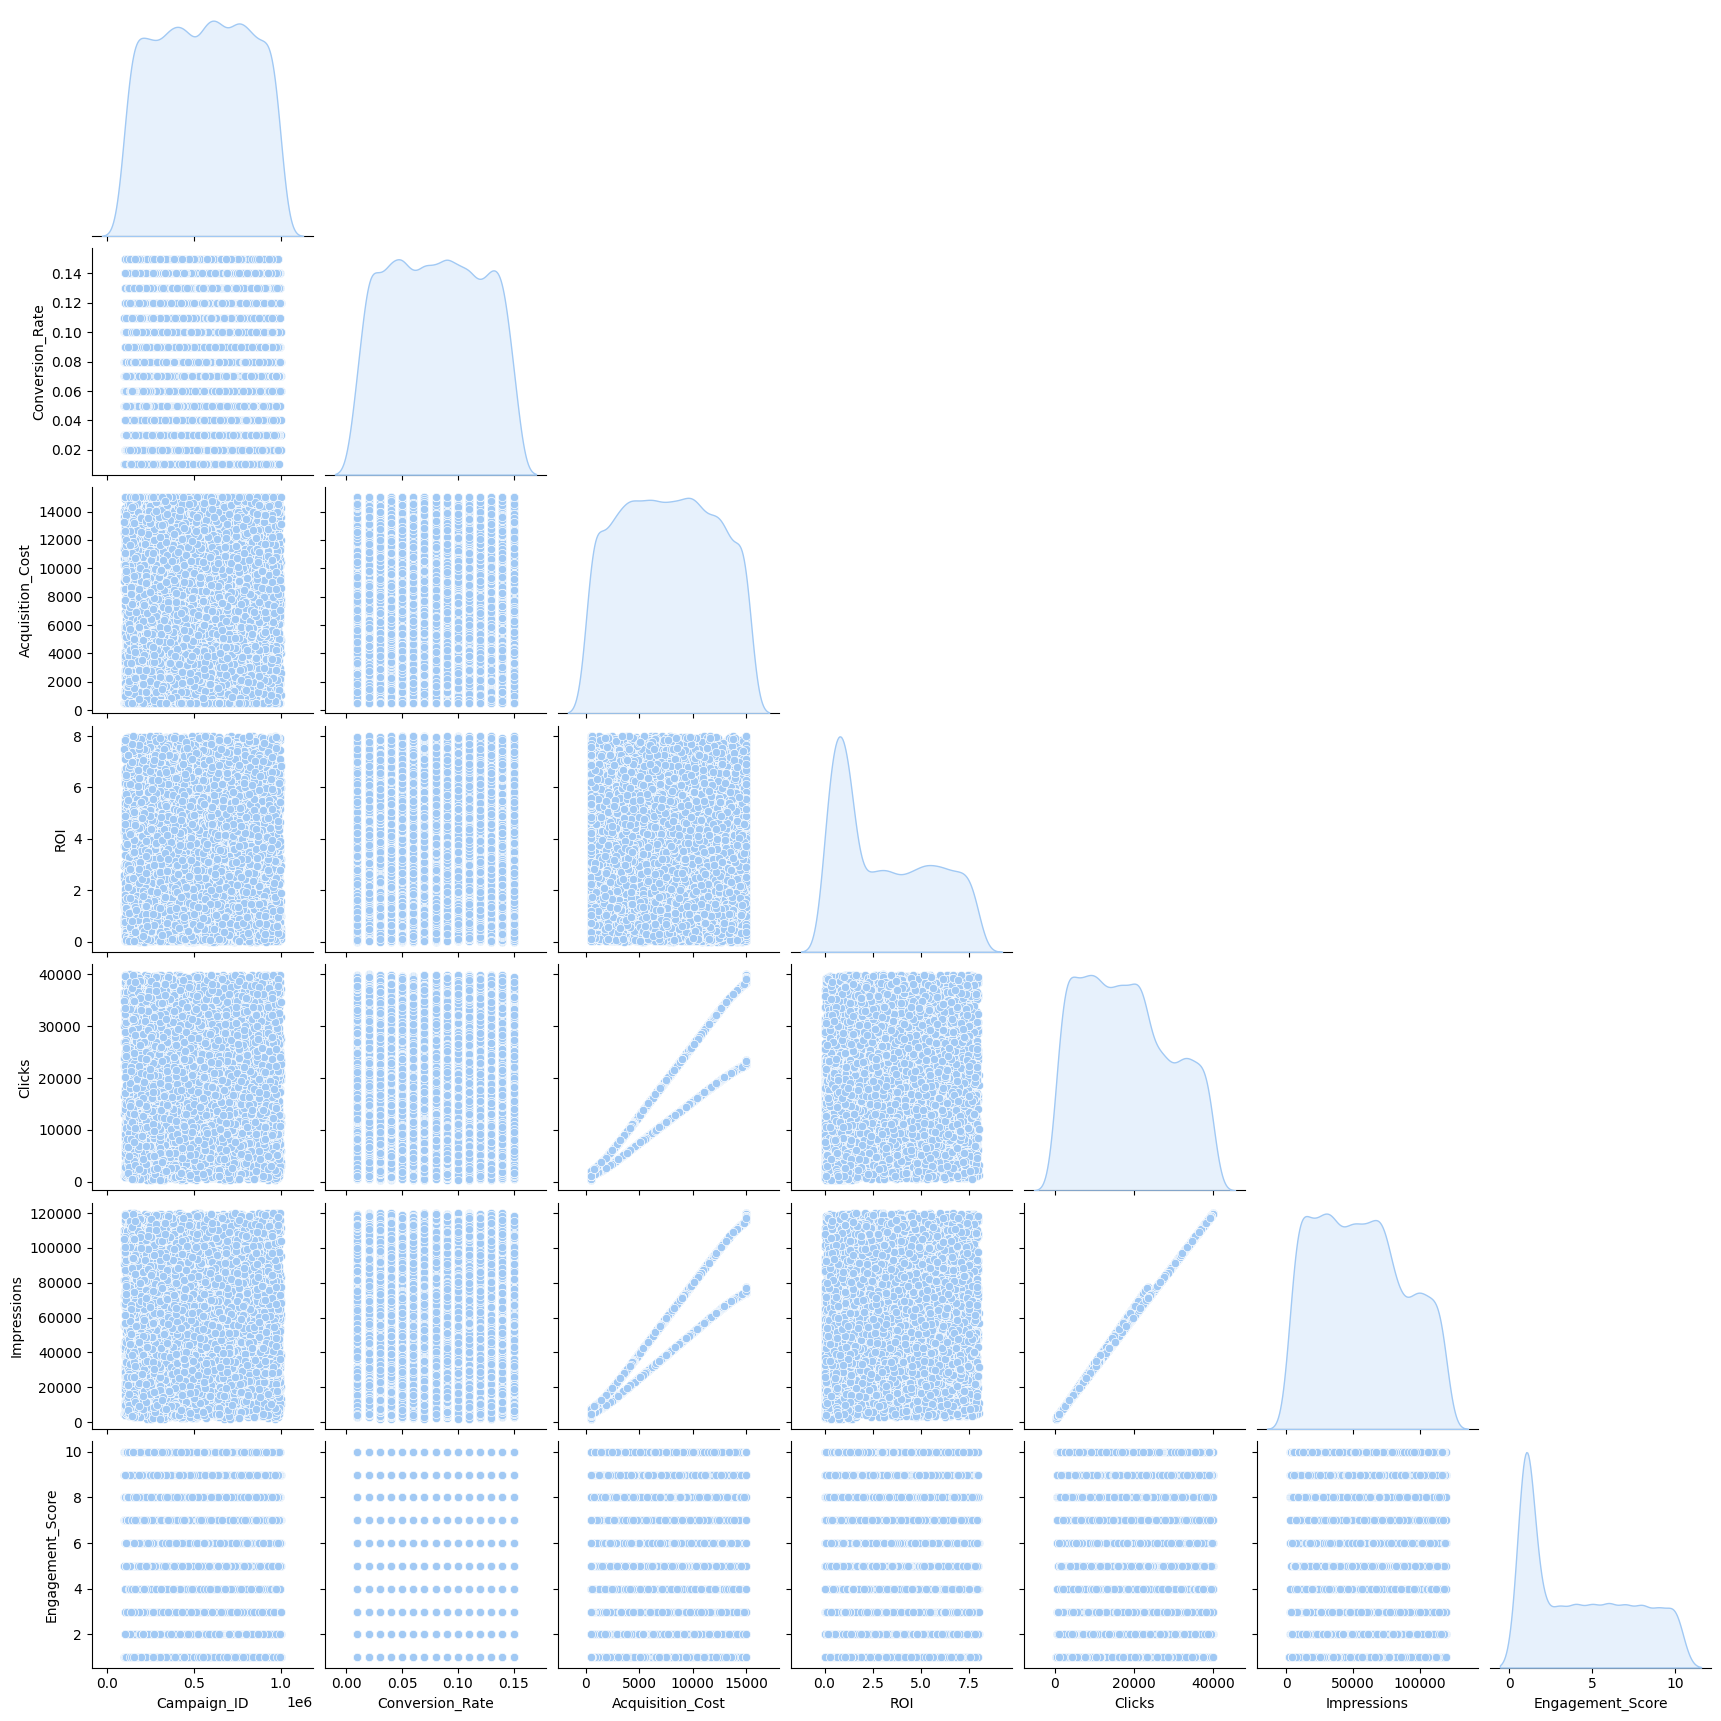

In [9]:
sns.pairplot(numeric_df, corner=True, diag_kind='kde')
plt.savefig('pairplot.png', dpi=300)
plt.show()

## Q1: How does the choice of social media platform impact engagement levels, and are certain platforms consistently more effective than others?

### Visualising the data distribution

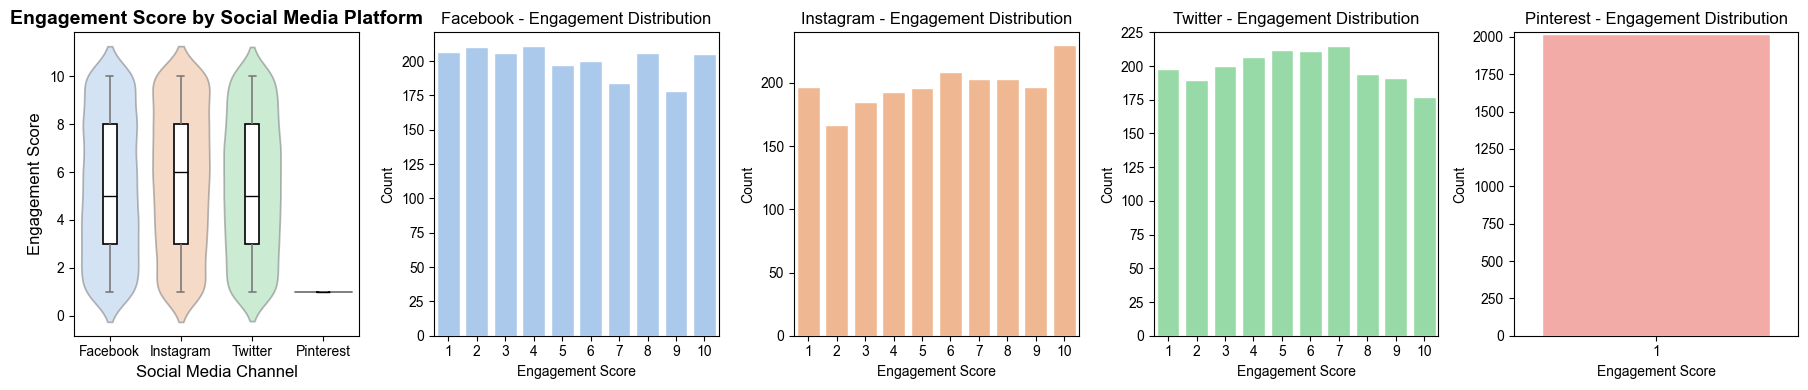

In [10]:
def plot_engagement_by_channel(df):
    channels = df['Channel_Used'].dropna().unique()
    num_channels = len(channels)
    palette = sns.color_palette("pastel", num_channels)

    fig, axes = plt.subplots(1, 5, figsize=(18, 4), sharey=False)
    sns.set_style("whitegrid")

    ax1 = axes[0]
    sns.violinplot(
        x='Channel_Used', y='Engagement_Score', hue='Channel_Used',
        data=df, inner=None, alpha=0.5, palette=palette, legend=False, ax=ax1
    )
    sns.boxplot(
        x='Channel_Used', y='Engagement_Score', data=df,
        width=0.2,
        boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.2),
        medianprops=dict(color='black'),
        whiskerprops=dict(linewidth=1.2),
        capprops=dict(linewidth=1.2),
        flierprops=dict(marker='o', markersize=3, alpha=0.3),
        zorder=3,
        ax=ax1
    )
    ax1.set_title("Engagement Score by Social Media Platform", fontsize=14, weight='bold')
    ax1.set_xlabel("Social Media Channel", fontsize=12)
    ax1.set_ylabel("Engagement Score", fontsize=12)

    for i, channel in enumerate(channels):
        ax = axes[i + 1]

        subset = df[(df['Channel_Used'] == channel) & (df['Engagement_Score'].notnull())]

        engagement_counts = subset['Engagement_Score'].value_counts().sort_index()

        sns.barplot(
            x=engagement_counts.index, y=engagement_counts.values,
            color=palette[i], ax=ax
        )
        ax.set_title(f"{channel} - Engagement Distribution", fontsize=12)
        ax.set_xlabel("Engagement Score", fontsize=10)
        ax.set_ylabel("Count", fontsize=10)

        ax.set_ylim(0, engagement_counts.max() + 10)

    plt.tight_layout()
    plt.savefig("platform_vs_engagement_hist.png", dpi=300)
    plt.show()

plot_engagement_by_channel(df)

### Checking for normality of engagement scores across groups (KS test as medium sized data)

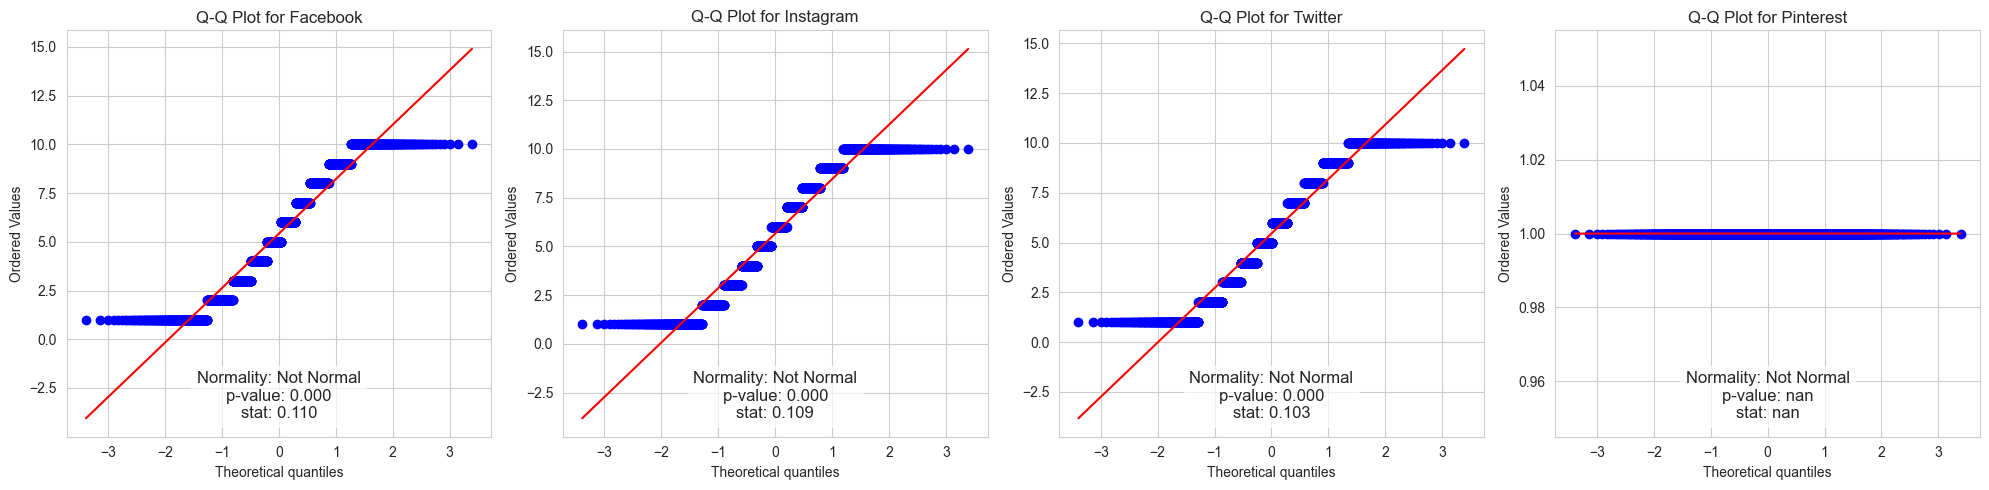

In [11]:
def plot_q_q_plot(data, ax, channel, color=None):
    stat, p_value = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    normality_result = "Normal" if p_value > 0.05 else "Not Normal"
    
    if color is None:
        stats.probplot(data, dist="norm", plot=ax)
    else:
        res = stats.probplot(data, dist="norm")
        x = res[0][0]
        y = res[0][1]
        slope, intercept, _ = res[1]
        ax.scatter(x, y, color=color)
        ax.plot(x, slope * x + intercept, color='red')

    ax.set_title(f"Q-Q Plot for {channel}")
    
    ax.text(0.5, 0.1, f"Normality: {normality_result}\np-value: {p_value:.3f}\nstat: {stat:.3f}",
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

channels = df['Channel_Used'].dropna().unique()
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, channel in enumerate(channels):
    data = df[df['Channel_Used'] == channel]['Engagement_Score'].dropna()
    data = data[np.isfinite(data)]
    plot_q_q_plot(data, axes[i], channel)

plt.tight_layout()
plt.savefig("qq_platform_vs_engagement.png", dpi=300)
plt.show()

### Checking for homogenity of variances (Levene's test)

In [12]:
def levene_test(data):
    stat, p_value = stats.levene(*data)    
    print(f"{styles.FG_YELLOW}\tStatistic: {stat:.4f}, p-value: {p_value:.4f}{styles.RESET}")
    if p_value > 0.05:
        print(f"{styles.FG_GREEN}\t✔ The variances are homogenous (fail to reject the null hypothesis).{styles.RESET}")
    else:
        print(f"{styles.FG_RED}\t✘ The variances are not homogenous (reject the null hypothesis).{styles.RESET}")

# Main execution
print(f"\n{styles.BOLD}{styles.FG_MAGENTA}Doing Levene's test for Homogeneity of Variances for all channels{styles.RESET}")
engagement_scores = [df[df['Channel_Used'] == channel]['Engagement_Score'].dropna() for channel in channels]
levene_test(engagement_scores)

print(f"\n{styles.BOLD}{styles.FG_MAGENTA}Doing Levene's test for Homogeneity of Variances with Pinterest removed (as it has constant values){styles.RESET}")
df_no_pinterest = df[df['Channel_Used'] != 'Pinterest']
channels_no_pinterest = df_no_pinterest['Channel_Used'].dropna().unique()
engagement_scores = [df[df['Channel_Used'] == channel]['Engagement_Score'].dropna() for channel in channels_no_pinterest]
levene_test(engagement_scores)


Doing Levene's test for Homogeneity of Variances for all channels
	Statistic: 1822.1527, p-value: 0.0000
	✘ The variances are not homogenous (reject the null hypothesis).

Doing Levene's test for Homogeneity of Variances with Pinterest removed (as it has constant values)
	Statistic: 1.1954, p-value: 0.3026
	✔ The variances are homogenous (fail to reject the null hypothesis).


### Doing Kruskal-Wallis Test (for all Channels) as data !Normal + !Homogenous

In [13]:
kruskal_result = stats.kruskal(
    df[df['Channel_Used'] == 'Facebook']['Engagement_Score'],
    df[df['Channel_Used'] == 'Instagram']['Engagement_Score'],
    df[df['Channel_Used'] == 'Twitter']['Engagement_Score'],
    df[df['Channel_Used'] == 'Pinterest']['Engagement_Score']
)
print(f"{styles.FG_YELLOW}Kruskal-Wallis p-value: {kruskal_result.pvalue:.4f}{styles.RESET}")

# If p-value < 0.05, perform pairwise comparisons using Mann-Whitney U test
if kruskal_result.pvalue < 0.05:
    print(f"\n{styles.FG_MAGENTA}{styles.BOLD}Significant difference found! Performing Mann-Whitney U pairwise comparisons with effect sizes:{styles.RESET}")
    channels = ['Facebook', 'Instagram', 'Twitter', 'Pinterest']
    for i in range(len(channels)):
        for j in range(i + 1, len(channels)):
            group1 = df[df['Channel_Used'] == channels[i]]['Engagement_Score']
            group2 = df[df['Channel_Used'] == channels[j]]['Engagement_Score']
            stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            
            # Calculate effect size (rank-biserial correlation)
            n1, n2 = len(group1), len(group2)
            r_rb = 1 - (2 * stat) / (n1 * n2)
            
            # Formatting output
            color = styles.FG_GREEN if p_value > 0.05 else styles.FG_RED
            result_text = "No significant difference" if p_value > 0.05 else "Significant difference"
            print(f"{color}→ {channels[i]} vs {channels[j]} | p-value: {p_value:.4f} ({result_text}) | Effect size (r_rb): {r_rb:.4f}{styles.RESET}")
else:
    print(f"{styles.FG_GREEN}✔ No statistically significant difference found across channels (Kruskal-Wallis p ≥ 0.05).{styles.RESET}")

Kruskal-Wallis p-value: 0.0000

Significant difference found! Performing Mann-Whitney U pairwise comparisons with effect sizes:
→ Facebook vs Instagram | p-value: 0.0082 (Significant difference) | Effect size (r_rb): 0.0481
→ Facebook vs Twitter | p-value: 0.6994 (No significant difference) | Effect size (r_rb): 0.0070
→ Facebook vs Pinterest | p-value: 0.0000 (Significant difference) | Effect size (r_rb): -0.8967
→ Instagram vs Twitter | p-value: 0.0200 (Significant difference) | Effect size (r_rb): -0.0424
→ Instagram vs Pinterest | p-value: 0.0000 (Significant difference) | Effect size (r_rb): -0.9005
→ Twitter vs Pinterest | p-value: 0.0000 (Significant difference) | Effect size (r_rb): -0.9008


### Doing Kruskal-Wallis Test (Pinterest Removed) as data !Normal + Homogenous

In [14]:
kruskal_result = stats.kruskal(
    df[df['Channel_Used'] == 'Facebook']['Engagement_Score'],
    df[df['Channel_Used'] == 'Instagram']['Engagement_Score'],
    df[df['Channel_Used'] == 'Twitter']['Engagement_Score']
)
print(f"{styles.FG_YELLOW}Kruskal-Wallis p-value: {kruskal_result.pvalue:.4f}{styles.RESET}")

# If p-value < 0.05, perform pairwise comparisons using Mann-Whitney U test
if kruskal_result.pvalue < 0.05:
    print(f"\n{styles.FG_MAGENTA}{styles.BOLD}Significant difference found! Performing Mann-Whitney U pairwise comparisons:{styles.RESET}")
    channels = ['Facebook', 'Instagram', 'Twitter']
    for i in range(len(channels)):
        for j in range(i + 1, len(channels)):
            group1 = df[df['Channel_Used'] == channels[i]]['Engagement_Score']
            group2 = df[df['Channel_Used'] == channels[j]]['Engagement_Score']
            stat, p_value = stats.mannwhitneyu(group1, group2)
            # Calculate effect size (rank-biserial correlation)
            n1, n2 = len(group1), len(group2)
            r_rb = 1 - (2 * stat) / (n1 * n2)
            
            # Formatting output
            color = styles.FG_GREEN if p_value > 0.05 else styles.FG_RED
            result_text = "No significant difference" if p_value > 0.05 else "Significant difference"
            print(f"{color}→ {channels[i]} vs {channels[j]} | p-value: {p_value:.4f} ({result_text}) | Effect size (r_rb): {r_rb:.4f}{styles.RESET}")
else:
    print(f"{styles.FG_GREEN}✔ No statistically significant difference found across channels (Kruskal-Wallis p ≥ 0.05).{styles.RESET}")

Kruskal-Wallis p-value: 0.0154

Significant difference found! Performing Mann-Whitney U pairwise comparisons:
→ Facebook vs Instagram | p-value: 0.0082 (Significant difference) | Effect size (r_rb): 0.0481
→ Facebook vs Twitter | p-value: 0.6994 (No significant difference) | Effect size (r_rb): 0.0070
→ Instagram vs Twitter | p-value: 0.0200 (Significant difference) | Effect size (r_rb): -0.0424


### 📊 **Effect of Social Media channel on User Engagement Scores**

---

#### 🧪 **Tests Summary**

| **Test**                        | **Result** |
|-------------------------------|------------|
| **Normality Test (KS Test)**   | ❌ None of the channels are normally distributed |
| **Levene’s Test (All Channels)** | ❌ Variances are not homogenous |
| **Levene’s Test (Without Pinterest)** | ✅ Variances are homogenous |
| **Kruskal-Wallis Test (All Channels)** | ✅ Significant difference exists between groups *(p < 0.05)* |
| **Kruskal-Wallis Test (Without Pinterest)** | ✅ Significant difference still exists *(p = 0.0154)* |

---

#### 📊 **Pairwise Mann-Whitney U Test Results**

| **Channel 1** | **Channel 2** | **p-value** | **Significance** |
|--------------|---------------|-------------|------------------|
| Facebook     | Instagram     | 0.0082      | ✅ Significant    |
| Facebook     | Twitter       | 0.6994      | ❌ Not Significant |
| Facebook     | Pinterest     | 0.0000      | ✅ Significant    |
| Instagram    | Twitter       | 0.0200      | ✅ Significant    |
| Instagram    | Pinterest     | 0.0000      | ✅ Significant    |
| Twitter      | Pinterest     | 0.0000      | ✅ Significant    |

*Subset without Pinterest:*

| **Channel 1** | **Channel 2** | **p-value** | **Significance** |
|--------------|---------------|-------------|------------------|
| Facebook     | Instagram     | 0.0082      | ✅ Significant    |
| Facebook     | Twitter       | 0.6994      | ❌ Not Significant |
| Instagram    | Twitter       | 0.0200      | ✅ Significant    |

---

### 🔍 **Final Conclusion**

📌 Based on non-parametric statistical analysis (Kruskal-Wallis and Mann-Whitney U):

- The choice of social media platform **does significantly impact** engagement levels.
- **Pinterest**, due to its constant engagement scores, shows statistically different behavior and skews variance homogeneity.
- Removing Pinterest still shows a significant difference between platforms, reinforcing the conclusion.
- **Instagram vs Facebook**, and **Instagram vs Twitter** show consistent significant differences.
- **Facebook and Twitter** do not differ significantly in engagement levels.

Therefore, **Instagram emerges as a more effective platform** in generating engagement, while **Pinterest is the least reliable due to constant scores**.

## Q2: What role does campaign duration play in determining success? Do shorter or longer campaigns lead to better engagement and conversions?

### Visualising the data distribution

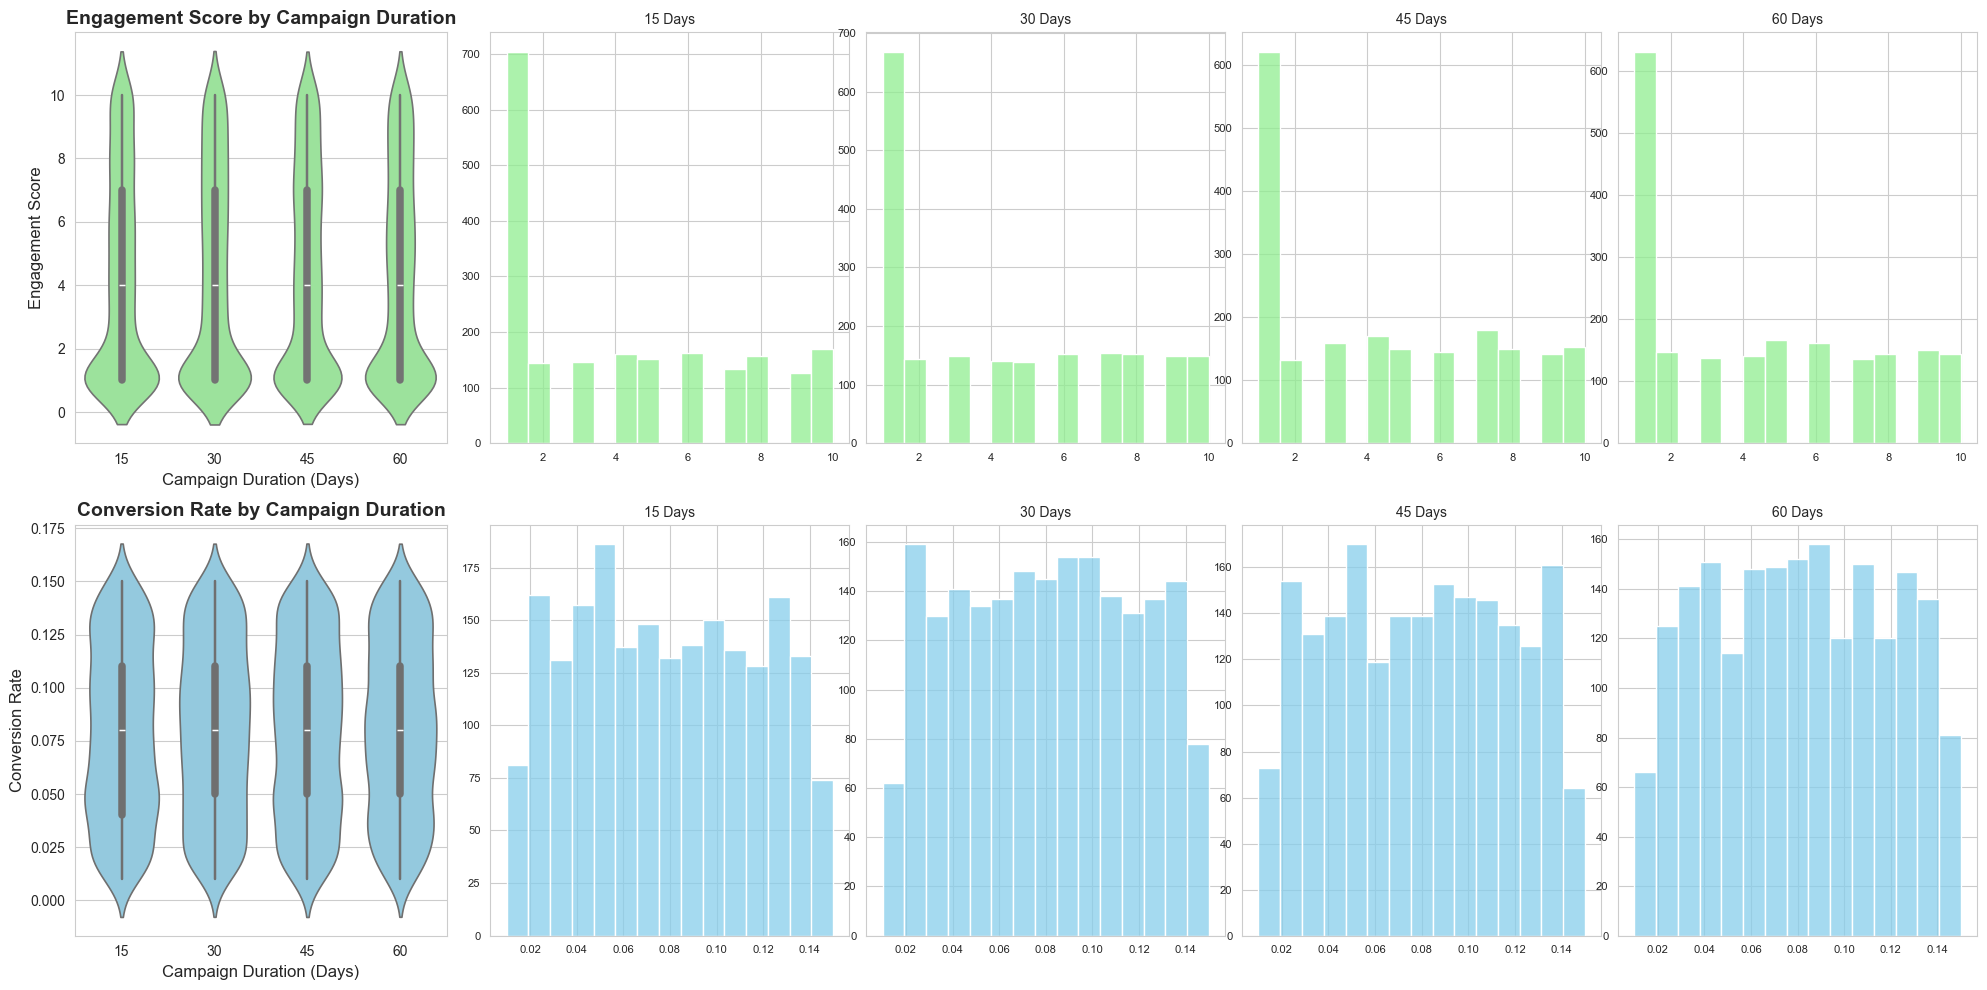

In [15]:
# Extract duration days
df['Duration_Days'] = df['Duration'].str.extract('(\d+)').astype(int)
durations = sorted(df['Duration_Days'].unique())

# Set seaborn theme
sns.set_style("whitegrid")

# Create the 2x2 layout
fig = plt.figure(figsize=(20, 10))
outer_gs = GridSpec(2, 2, width_ratios=[1, 4], height_ratios=[1, 1])

# --- Plot 1: Engagement Score Violin + Box ---
ax1 = fig.add_subplot(outer_gs[0, 0])
sns.violinplot(
    x='Duration_Days', y='Engagement_Score',
    data=df, inner='box', linewidth=1.2, color='lightgreen', ax=ax1
)
ax1.set_title("Engagement Score by Campaign Duration", fontsize=14, weight='bold')
ax1.set_xlabel("Campaign Duration (Days)", fontsize=12)
ax1.set_ylabel("Engagement Score", fontsize=12)

# --- Plot 2: Engagement Score Histograms (1 per duration) ---
gs1 = GridSpecFromSubplotSpec(1, len(durations), subplot_spec=outer_gs[0, 1])
for i, duration in enumerate(durations):
    ax = fig.add_subplot(gs1[0, i])
    subset = df[df['Duration_Days'] == duration]
    sns.histplot(subset['Engagement_Score'], bins=15, ax=ax, color='lightgreen')
    ax.set_title(f"{duration} Days", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(labelsize=8)

# --- Plot 3: Conversion Rate Violin + Box ---
ax2 = fig.add_subplot(outer_gs[1, 0])
sns.violinplot(
    x='Duration_Days', y='Conversion_Rate',
    data=df, inner='box', linewidth=1.2, color='skyblue', ax=ax2
)
ax2.set_title("Conversion Rate by Campaign Duration", fontsize=14, weight='bold')
ax2.set_xlabel("Campaign Duration (Days)", fontsize=12)
ax2.set_ylabel("Conversion Rate", fontsize=12)

# --- Plot 4: Conversion Rate Histograms (1 per duration) ---
gs2 = GridSpecFromSubplotSpec(1, len(durations), subplot_spec=outer_gs[1, 1])
for i, duration in enumerate(durations):
    ax = fig.add_subplot(gs2[0, i])
    subset = df[df['Duration_Days'] == duration]
    sns.histplot(subset['Conversion_Rate'], bins=15, ax=ax, color='skyblue')
    ax.set_title(f"{duration} Days", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.savefig("hist_duration_vs_engagement_conversion.png", dpi=300)
plt.show()

### Checking for Normality

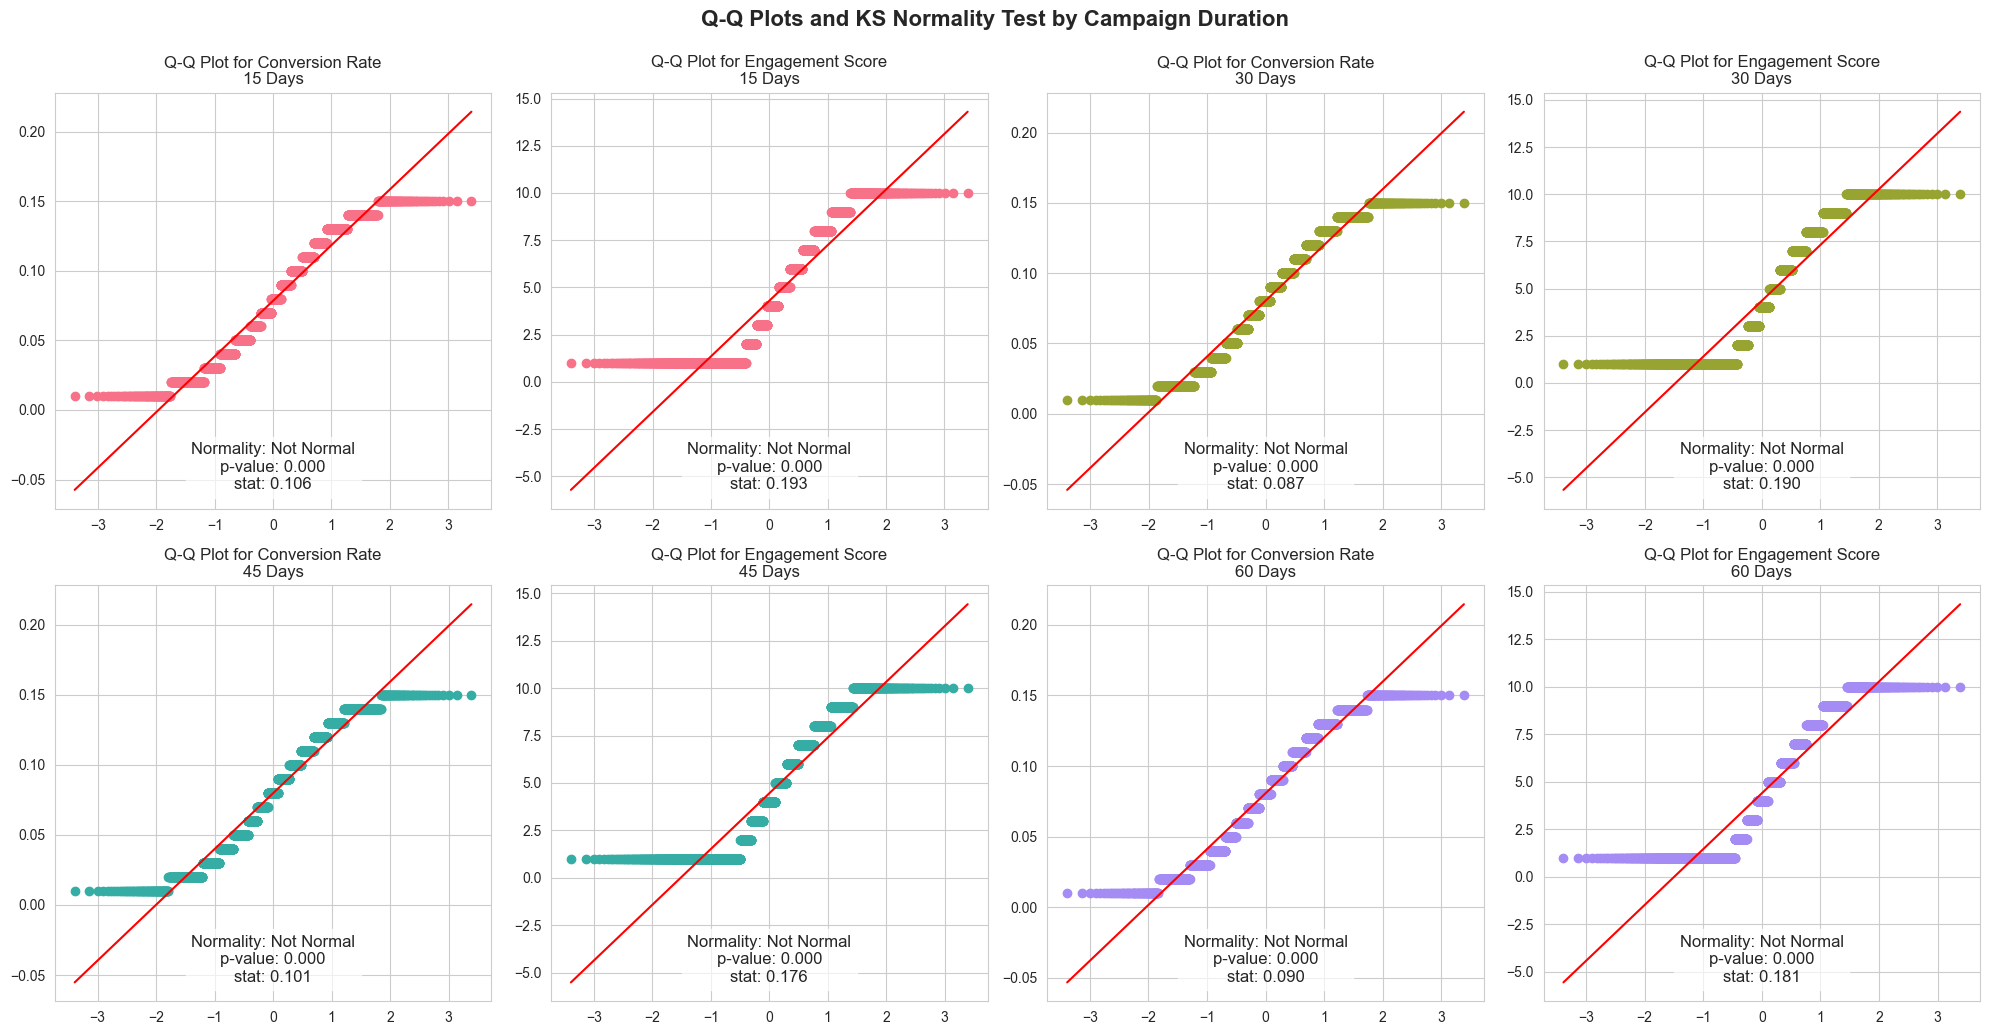

In [16]:
unique_durations = sorted(df['Duration_Days'].unique())

num_durations = len(unique_durations)
num_cols = 4  # 2 plots per group × 2 groups per row
num_rows = 2  # total 4 groups / 2 groups per row = 2 rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
colors = sns.color_palette("husl", num_durations)

for i, duration in enumerate(unique_durations):
    row = i // 2
    col_start = (i % 2) * 2  # 0 or 2
    ax1 = axes[row, col_start]
    ax2 = axes[row, col_start + 1]

    subset = df[df['Duration_Days'] == duration]

    # Conversion Rate Q-Q Plot
    sample_cr = subset['Conversion_Rate'].dropna()
    plot_q_q_plot(sample_cr, ax1, f"Conversion Rate\n{duration} Days", color=colors[i])

    # Engagement Score Q-Q Plot
    sample_es = subset['Engagement_Score'].dropna()
    plot_q_q_plot(sample_es, ax2, f"Engagement Score\n{duration} Days", color=colors[i])

plt.tight_layout()
plt.suptitle("Q-Q Plots and KS Normality Test by Campaign Duration", fontsize=16, weight='bold', y=1.03)
plt.savefig("qq_duration_vs_engagement_conversion.png", dpi=300)
plt.show()


> None of the above quantities are normally distributed.

### Testing for homogenity of variances

In [17]:
# Group the data by 'Duration_Days'
unique_durations = df['Duration'].unique()

# Levene's test on Conversion Rate
conversion_rate_data = [df[df['Duration'] == duration]['Conversion_Rate'].dropna() for duration in unique_durations]
print(f"\n{styles.BOLD}{styles.FG_MAGENTA}Levene's test for Conversion Rate{styles.RESET}")
levene_test(conversion_rate_data)

# Levene's test on Engagement Score
engagement_score_data = [df[df['Duration'] == duration]['Engagement_Score'].dropna() for duration in unique_durations]
print(f"\n{styles.BOLD}{styles.FG_MAGENTA}Levene's test for Engagement Score{styles.RESET}")
levene_test(engagement_score_data)


Levene's test for Conversion Rate
	Statistic: 0.8023, p-value: 0.4924
	✔ The variances are homogenous (fail to reject the null hypothesis).

Levene's test for Engagement Score
	Statistic: 0.4922, p-value: 0.6877
	✔ The variances are homogenous (fail to reject the null hypothesis).


> Non-normal + Homogeneous variance groups for both Conversion Rate and Engagement Scores

### Doing Kruskal-Wallis Test !Normal + Homogenous

In [18]:
# Prepare duration groups for analysis
duration_groups_engagement = [df[df['Duration_Days'] == d]['Engagement_Score'].dropna() for d in unique_durations]
duration_groups_conversion = [df[df['Duration_Days'] == d]['Conversion_Rate'].dropna() for d in unique_durations]

# 1. Kruskal-Wallis test for Engagement Score
print(f"\n{styles.BOLD}{styles.FG_YELLOW}Kruskal-Wallis Test: Engagement Score vs Duration{styles.RESET}")
kruskal_engagement = stats.kruskal(*duration_groups_engagement)
print(f"{styles.FG_YELLOW}p-value: {kruskal_engagement.pvalue:.4f}{styles.RESET}")

if kruskal_engagement.pvalue < 0.05:
    print(f"{styles.FG_MAGENTA}{styles.BOLD}Significant difference found! Pairwise Mann-Whitney U tests for Engagement Score:{styles.RESET}")
    for i in range(len(unique_durations)):
        for j in range(i + 1, len(unique_durations)):
            g1 = duration_groups_engagement[i]
            g2 = duration_groups_engagement[j]
            stat, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
            color = styles.FG_GREEN if p_value > 0.05 else styles.FG_RED
            result_text = "No significant difference" if p_value > 0.05 else "Significant difference"
            print(f"{color}→ {channels[i]} vs {channels[j]} | p-value: {p_value:.4f} ({result_text}){styles.RESET}")
else:
    print(f"{styles.FG_GREEN}✔ No statistically significant difference in Engagement Score across durations.{styles.RESET}")

# 2. Kruskal-Wallis test for Conversion Rate
print(f"\n{styles.BOLD}{styles.FG_YELLOW}Kruskal-Wallis Test: Conversion Rate vs Duration{styles.RESET}")
kruskal_conversion = stats.kruskal(*duration_groups_conversion)
print(f"{styles.FG_YELLOW}p-value: {kruskal_conversion.pvalue:.4f}{styles.RESET}")

if kruskal_conversion.pvalue < 0.05:
    print(f"{styles.FG_MAGENTA}{styles.BOLD}Significant difference found! Pairwise Mann-Whitney U tests for Conversion Rate:{styles.RESET}")
    for i in range(len(unique_durations)):
        for j in range(i + 1, len(unique_durations)):
            g1 = duration_groups_conversion[i]
            g2 = duration_groups_conversion[j]
            stat, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
            color = styles.FG_GREEN if p_value > 0.05 else styles.FG_RED
            result_text = "No significant difference" if p_value > 0.05 else "Significant difference"
            print(f"{color}→ {channels[i]} vs {channels[j]} | p-value: {p_value:.4f} ({result_text}){styles.RESET}")
else:
    print(f"{styles.FG_GREEN}✔ No statistically significant difference in Conversion Rate across durations.{styles.RESET}")



Kruskal-Wallis Test: Engagement Score vs Duration
p-value: nan
✔ No statistically significant difference in Engagement Score across durations.

Kruskal-Wallis Test: Conversion Rate vs Duration
p-value: nan
✔ No statistically significant difference in Conversion Rate across durations.


### 📊 **Role of Campaign Duration in Engagement & Conversion**

---

#### 🧪 **Tests Summary**

| **Test**                        | **Result** |
|-------------------------------|------------|
| **Normality Test (KS Test)**   | ❌ None of the channels are normally distributed |
| **Levene’s Test (Engagement Scores)** | ✅ Variances are **homogenous** (`p = 0.6877`) |
| **Levene’s Test (Conversion Rate)** | ✅ Variances are **homogenous** (`p = 0.4924`) |
| **Kruskal-Wallis Test (Engagement Score vs Duration)** | `p = 0.3088` → ❌ No significant difference |
| **Kruskal-Wallis Test (Conversion Rate vs Duration)** | `p = 0.3011` → ❌ No significant difference |

---

### 🔍 **Final Conclusion**

📌 Based on non-parametric statistical analysis (Kruskal-Wallis and Mann-Whitney U):

Campaign duration **does not play a statistically significant role** in determining **engagement** or **conversion success**. Whether a campaign runs for a shorter or longer duration, it **does not significantly affect** the outcomes in terms of **engagement scores** or **conversion rates** based on the available data.

## Q3: How do geographic and language differences influence ad engagement and conversion rates? Are some locations or languages more responsive to ads?

### Visualising the data distribution

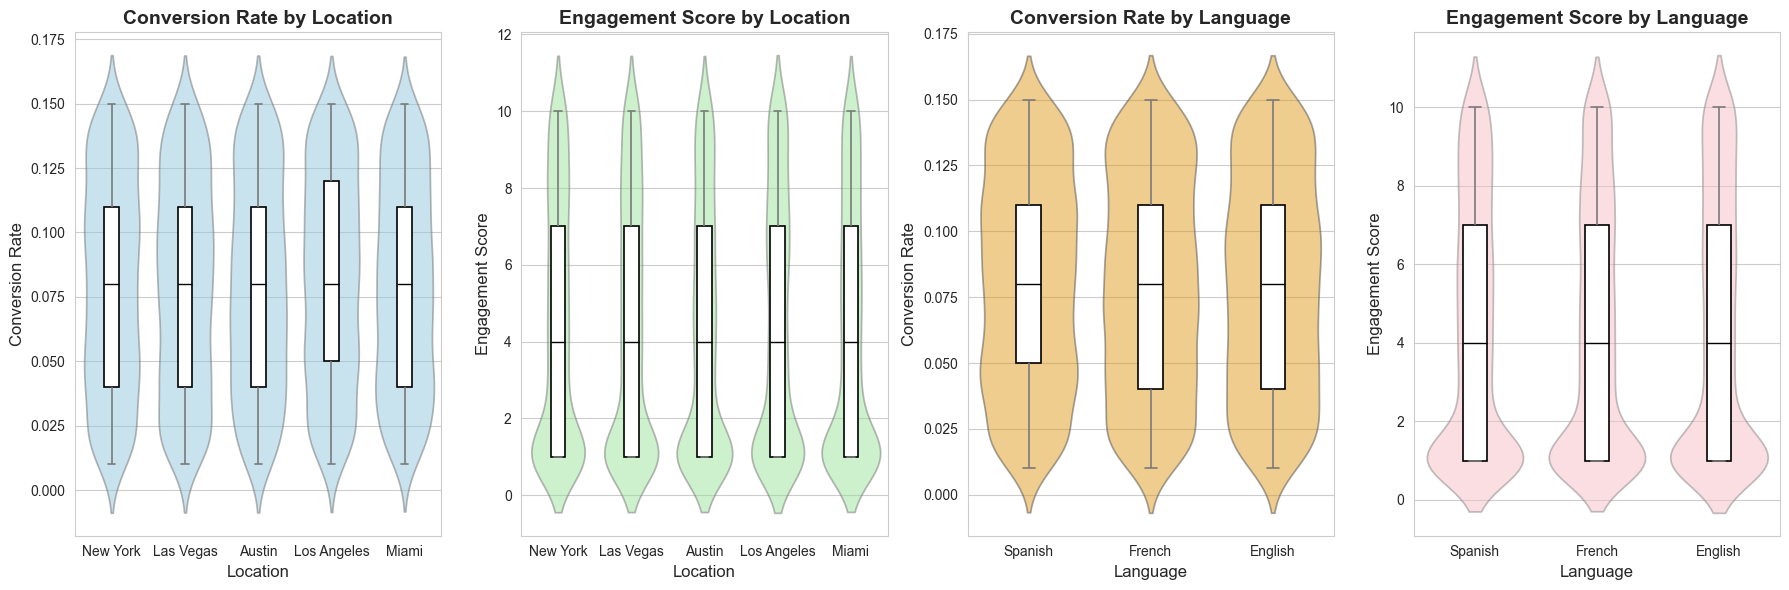

In [19]:
# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=False)

# --- Plot 1: Conversion Rate vs Location ---
ax1 = axes[0]
sns.violinplot(
    x='Location', y='Conversion_Rate',
    data=df, inner=None, alpha=0.5, color='skyblue', ax=ax1
)
sns.boxplot(
    x='Location', y='Conversion_Rate', data=df,
    width=0.2,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.2),
    medianprops=dict(color='black'),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(marker='o', markersize=3, alpha=0.3),
    zorder=3,
    ax=ax1
)
ax1.set_title("Conversion Rate by Location", fontsize=14, weight='bold')
ax1.set_xlabel("Location", fontsize=12)
ax1.set_ylabel("Conversion Rate", fontsize=12)

# --- Plot 2: Engagement Score vs Location ---
ax2 = axes[1]
sns.violinplot(
    x='Location', y='Engagement_Score',
    data=df, inner=None, alpha=0.5, color='lightgreen', ax=ax2
)
sns.boxplot(
    x='Location', y='Engagement_Score', data=df,
    width=0.2,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.2),
    medianprops=dict(color='black'),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(marker='o', markersize=3, alpha=0.3),
    zorder=3,
    ax=ax2
)
ax2.set_title("Engagement Score by Location", fontsize=14, weight='bold')
ax2.set_xlabel("Location", fontsize=12)
ax2.set_ylabel("Engagement Score", fontsize=12)

# --- Plot 3: Conversion Rate vs Language ---
ax3 = axes[2]
sns.violinplot(
    x='Language', y='Conversion_Rate',
    data=df, inner=None, alpha=0.5, color='orange', ax=ax3
)
sns.boxplot(
    x='Language', y='Conversion_Rate', data=df,
    width=0.2,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.2),
    medianprops=dict(color='black'),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(marker='o', markersize=3, alpha=0.3),
    zorder=3,
    ax=ax3
)
ax3.set_title("Conversion Rate by Language", fontsize=14, weight='bold')
ax3.set_xlabel("Language", fontsize=12)
ax3.set_ylabel("Conversion Rate", fontsize=12)

# --- Plot 4: Engagement Score vs Language ---
ax4 = axes[3]
sns.violinplot(
    x='Language', y='Engagement_Score',
    data=df, inner=None, alpha=0.5, color='lightpink', ax=ax4
)
sns.boxplot(
    x='Language', y='Engagement_Score', data=df,
    width=0.2,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.2),
    medianprops=dict(color='black'),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(marker='o', markersize=3, alpha=0.3),
    zorder=3,
    ax=ax4
)
ax4.set_title("Engagement Score by Language", fontsize=14, weight='bold')
ax4.set_xlabel("Language", fontsize=12)
ax4.set_ylabel("Engagement Score", fontsize=12)

plt.tight_layout()
plt.savefig("hist_location_language_vs_engagement_conversion.png", dpi=300)
plt.show()

### Testing for normality of each of the group

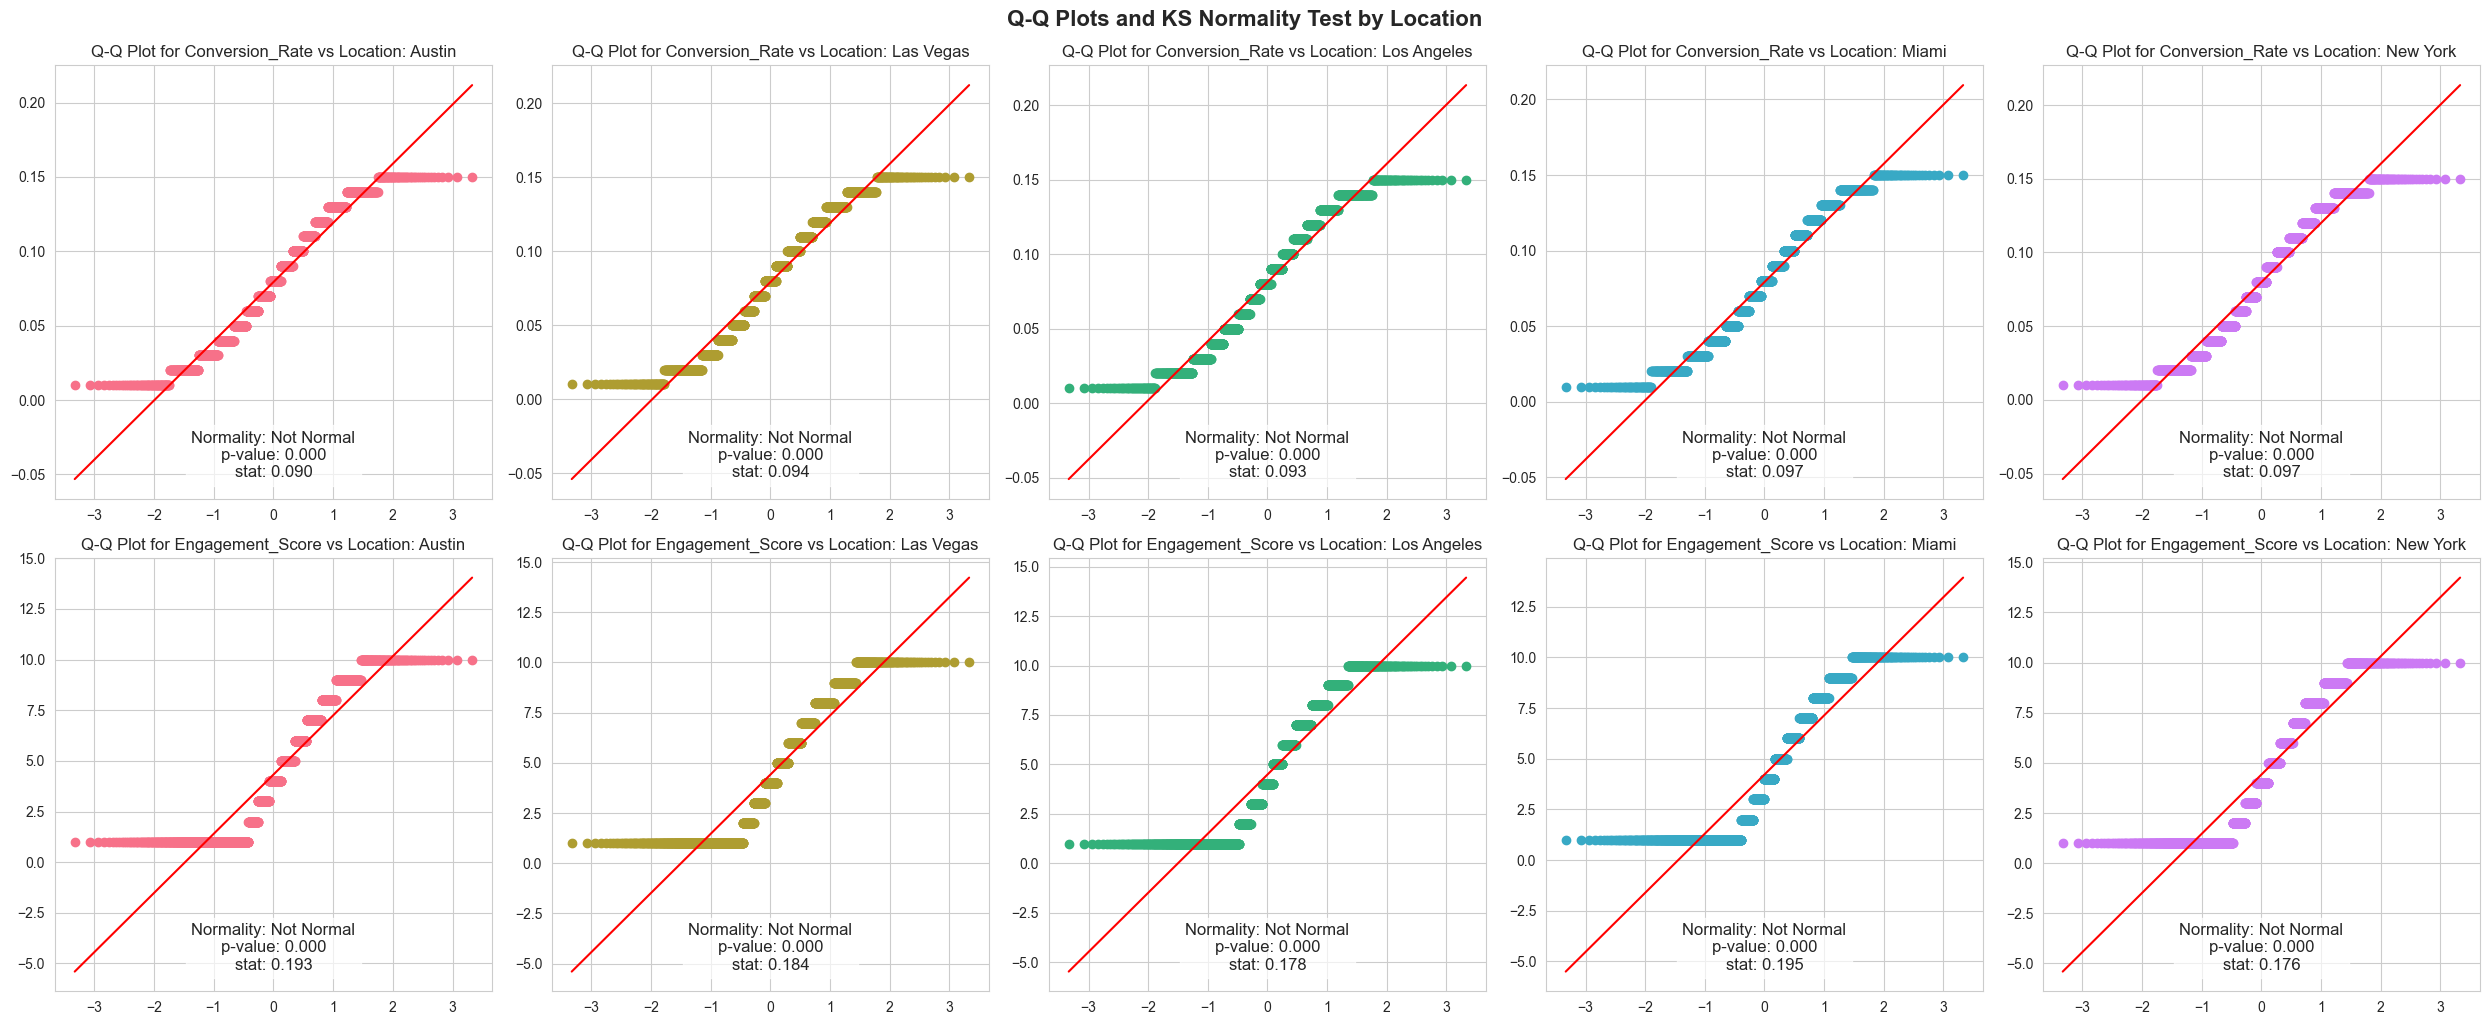

In [20]:
unique_locations = sorted(df['Location'].unique())
num_locations = len(unique_locations)
fig, axes = plt.subplots(2, num_locations, figsize=(25, 10))

colors = sns.color_palette("husl", num_locations)  # Generate unique colors

for i, location in enumerate(unique_locations):
    subset = df[df['Location'] == location]
    sample = subset['Conversion_Rate'].dropna()
    plot_q_q_plot(sample, axes[0, i], f"Conversion_Rate vs Location: {location}", color = colors[i])

for i, location in enumerate(unique_locations):
    subset = df[df['Location'] == location]
    sample = subset['Engagement_Score'].dropna()
    plot_q_q_plot(sample, axes[1, i], f"Engagement_Score vs Location: {location}", color = colors[i])

plt.tight_layout()
plt.suptitle("Q-Q Plots and KS Normality Test by Location", fontsize=16, weight='bold', y=1.02)
plt.savefig("qq_location_vs_engagement_converstion.png", dpi=300)
plt.show()

> No group is normal

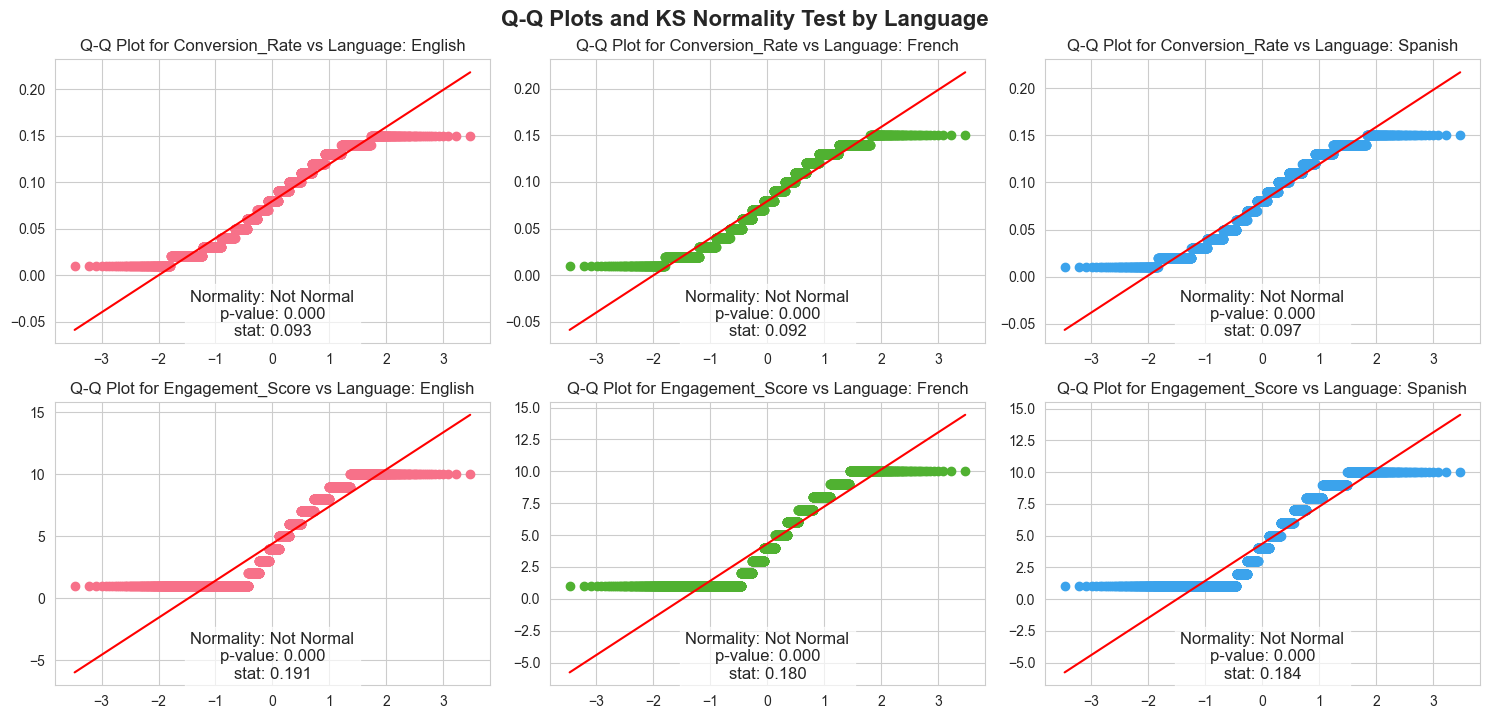

In [21]:
unique_languages = sorted(df['Language'].unique())
num_languages = len(unique_languages)
fig, axes = plt.subplots(2, num_languages, figsize=(15, 7))

colors = sns.color_palette("husl", num_languages)  # Generate unique colors

for i, language in enumerate(unique_languages):
    subset = df[df['Language'] == language]
    sample = subset['Conversion_Rate'].dropna()
    plot_q_q_plot(sample, axes[0, i], f"Conversion_Rate vs Language: {language}", color = colors[i])

for i, language in enumerate(unique_languages):
    subset = df[df['Language'] == language]
    sample = subset['Engagement_Score'].dropna()
    plot_q_q_plot(sample, axes[1, i], f"Engagement_Score vs Language: {language}", color = colors[i])

plt.tight_layout()
plt.suptitle("Q-Q Plots and KS Normality Test by Language", fontsize=16, weight='bold', y=1.02)
plt.savefig("qq_language_vs_engagement_conversion.png", dpi=300)
plt.show()

> No group is normal

### Testing for homogenity of variance

In [22]:
# Main execution
print(f"\n{styles.BOLD}{styles.FG_MAGENTA}Doing Levene's test for Homogeneity of Variances for:{styles.RESET}")

# Conversion Rate vs Location
print(f"\n{styles.BOLD}{styles.FG_MAGENTA}CONVERSION RATE based on LOCATIONS{styles.RESET}")
engagement_scores = [df[df['Location'] == location]['Conversion_Rate'].dropna() for location in unique_locations]
levene_test(engagement_scores)

# Engagement Score vs Location
print(f"\n{styles.BOLD}{styles.FG_MAGENTA}ENGAGEMENT SCORE based on LOCATIONS{styles.RESET}")
engagement_scores = [df[df['Location'] == location]['Engagement_Score'].dropna() for location in unique_locations]
levene_test(engagement_scores)

# Conversion Rate vs Language
print(f"\n{styles.BOLD}{styles.FG_MAGENTA}CONVERSION RATE based on LANGUAGES{styles.RESET}")
engagement_scores = [df[df['Language'] == language]['Conversion_Rate'].dropna() for language in unique_languages]
levene_test(engagement_scores)

# Engagement Score vs Language
print(f"\n{styles.BOLD}{styles.FG_MAGENTA}ENGAGEMENT SCORE based on LANGUAGES{styles.RESET}")
engagement_scores = [df[df['Language'] == language]['Engagement_Score'].dropna() for language in unique_languages]
levene_test(engagement_scores)


Doing Levene's test for Homogeneity of Variances for:

CONVERSION RATE based on LOCATIONS
	Statistic: 0.6816, p-value: 0.6046
	✔ The variances are homogenous (fail to reject the null hypothesis).

ENGAGEMENT SCORE based on LOCATIONS
	Statistic: 0.7834, p-value: 0.5357
	✔ The variances are homogenous (fail to reject the null hypothesis).

CONVERSION RATE based on LANGUAGES
	Statistic: 0.3173, p-value: 0.7282
	✔ The variances are homogenous (fail to reject the null hypothesis).

ENGAGEMENT SCORE based on LANGUAGES
	Statistic: 4.9331, p-value: 0.0072
	✘ The variances are not homogenous (reject the null hypothesis).


### Doing Kruskal-Wallis Test as data is !Normal + Homogenous/!Homogeneous

In [23]:
# Prepare location groups for analysis
location_groups_engagement = [df[df['Location'] == loc]['Engagement_Score'].dropna() for loc in unique_locations]
location_groups_conversion = [df[df['Location'] == loc]['Conversion_Rate'].dropna() for loc in unique_locations]

# Prepare language groups for analysis
language_groups_engagement = [df[df['Language'] == lang]['Engagement_Score'].dropna() for lang in unique_languages]
language_groups_conversion = [df[df['Language'] == lang]['Conversion_Rate'].dropna() for lang in unique_languages]

# 1. Kruskal-Wallis test for Engagement Score based on Location
print(f"\n{styles.BOLD}{styles.FG_YELLOW}Kruskal-Wallis Test: Engagement Score vs Location{styles.RESET}")
kruskal_engagement = stats.kruskal(*location_groups_engagement)
print(f"{styles.FG_YELLOW}p-value: {kruskal_engagement.pvalue:.4f}{styles.RESET}")

if kruskal_engagement.pvalue < 0.05:
    print(f"{styles.FG_MAGENTA}{styles.BOLD}Significant difference found! Pairwise Mann-Whitney U tests for Engagement Score based on Location:{styles.RESET}")
    for i in range(len(unique_locations)):
        for j in range(i + 1, len(unique_locations)):
            g1 = location_groups_engagement[i]
            g2 = location_groups_engagement[j]
            stat, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
            color = styles.FG_GREEN if p > 0.05 else styles.FG_RED
            result_text = "No significant difference" if p > 0.05 else "Significant difference"
            print(f"{color}→ {unique_locations[i]} vs {unique_locations[j]} | p-value: {p:.4f} ({result_text}){styles.RESET}")

else:
    print(f"{styles.FG_GREEN}✔ No statistically significant difference in Engagement Score across Locations.{styles.RESET}")

# 2. Kruskal-Wallis test for Conversion Rate
print(f"\n{styles.BOLD}{styles.FG_YELLOW}Kruskal-Wallis Test: Conversion Rate vs Location{styles.RESET}")
kruskal_conversion = stats.kruskal(*location_groups_conversion)
print(f"{styles.FG_YELLOW}p-value: {kruskal_conversion.pvalue:.4f}{styles.RESET}")

if kruskal_conversion.pvalue < 0.05:
    print(f"{styles.FG_MAGENTA}{styles.BOLD}Significant difference found! Pairwise Mann-Whitney U tests for Conversion Rate based on Location:{styles.RESET}")
    for i in range(len(unique_locations)):
        for j in range(i + 1, len(unique_locations)):
            g1 = location_groups_conversion[i]
            g2 = location_groups_conversion[j]
            stat, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
            color = styles.FG_GREEN if p > 0.05 else styles.FG_RED
            result_text = "No significant difference" if p > 0.05 else "Significant difference"
            print(f"{color}→ {unique_locations[i]} vs {unique_locations[j]} | p-value: {p:.4f} ({result_text}){styles.RESET}")

else:
    print(f"{styles.FG_GREEN}✔ No statistically significant difference in Conversion Rate across Locations.{styles.RESET}")

# 3. Kruskal-Wallis test for Engagement Score based on Language
print(f"\n{styles.BOLD}{styles.FG_YELLOW}Kruskal-Wallis Test: Engagement Score vs Language{styles.RESET}")
kruskal_engagement = stats.kruskal(*language_groups_engagement)
print(f"{styles.FG_YELLOW}p-value: {kruskal_engagement.pvalue:.4f}{styles.RESET}")

if kruskal_engagement.pvalue < 0.05:
    print(f"{styles.FG_MAGENTA}{styles.BOLD}Significant difference found! Pairwise Mann-Whitney U tests for Engagement Score based on Language:{styles.RESET}")
    for i in range(len(unique_languages)):
        for j in range(i + 1, len(unique_languages)):
            g1 = language_groups_engagement[i]
            g2 = language_groups_engagement[j]
            stat, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
            color = styles.FG_GREEN if p > 0.05 else styles.FG_RED
            result_text = "No significant difference" if p > 0.05 else "Significant difference"
            print(f"{color}→ {unique_languages[i]} vs {unique_languages[j]} | p-value: {p:.4f} ({result_text}){styles.RESET}")

else:
    print(f"{styles.FG_GREEN}✔ No statistically significant difference in Engagement Score across Languages.{styles.RESET}")

# 4. Kruskal-Wallis test for Conversion Rate
print(f"\n{styles.BOLD}{styles.FG_YELLOW}Kruskal-Wallis Test: Conversion Rate vs Language{styles.RESET}")
kruskal_conversion = stats.kruskal(*language_groups_conversion)
print(f"{styles.FG_YELLOW}p-value: {kruskal_conversion.pvalue:.4f}{styles.RESET}")

if kruskal_conversion.pvalue < 0.05:
    print(f"{styles.FG_MAGENTA}{styles.BOLD}Significant difference found! Pairwise Mann-Whitney U tests for Conversion Rate based on Language:{styles.RESET}")
    for i in range(len(unique_languages)):
        for j in range(i + 1, len(unique_languages)):
            g1 = language_groups_conversion[i]
            g2 = language_groups_conversion[j]
            stat, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
            color = styles.FG_GREEN if p > 0.05 else styles.FG_RED
            result_text = "No significant difference" if p > 0.05 else "Significant difference"
            print(f"{color}→ {unique_languages[i]} vs {unique_languages[j]} | p-value: {p:.4f} ({result_text}){styles.RESET}")

else:
    print(f"{styles.FG_GREEN}✔ No statistically significant difference in Conversion Rate across Languages.{styles.RESET}")



Kruskal-Wallis Test: Engagement Score vs Location
p-value: 0.1212
✔ No statistically significant difference in Engagement Score across Locations.

Kruskal-Wallis Test: Conversion Rate vs Location
p-value: 0.5028
✔ No statistically significant difference in Conversion Rate across Locations.

Kruskal-Wallis Test: Engagement Score vs Language
p-value: 0.8735
✔ No statistically significant difference in Engagement Score across Languages.

Kruskal-Wallis Test: Conversion Rate vs Language
p-value: 0.7446
✔ No statistically significant difference in Conversion Rate across Languages.


### 📊 Impact of Location and Language on Ad Engagement & Conversion

This report summarizes the impact of **geographic (Location)** and **linguistic (Language)** differences on **ad engagement** and **conversion rates**. Since none of the groups were normally distributed, non-parametric methods will be used for further analysis.

We conducted **Levene’s Test** to evaluate the **homogeneity of variances**—a key assumption for parametric tests like ANOVA. Below are the findings:

---

### 🧪 Levene’s Test for Homogeneity of Variance

| Comparison                         | Levene Statistic | p-value  | Homogeneity of Variance?           |
|------------------------------------|------------------|----------|------------------------------------|
| Conversion Rate by Location        | 0.6816           | 0.6046   | ✅ Variances are homogenous        |
| Engagement Score by Location       | 0.7834           | 0.5357   | ✅ Variances are homogenous        |
| Conversion Rate by Language        | 0.3173           | 0.7282   | ✅ Variances are homogenous        |
| Engagement Score by Language       | 4.9331           | 0.0072   | ❌ Variances are **not** homogenous|

---

### 📌 Key Observations

- **Geographic Differences**:
  - Both **conversion rate** and **engagement score** show **homogeneous variances** across different locations.
  - This allows for **comparative tests** (e.g., Kruskal-Wallis) to analyze if median differences exist without worrying about unequal variance.

- **Language Differences**:
  - While **conversion rates** are consistent across languages (homogeneous variances),
  - **Engagement scores** show **significant heterogeneity** in variance across languages.
    - This indicates that **user interaction with ads may vary drastically based on language**.
    - Use **Welch’s ANOVA** or **non-parametric tests** like **Kruskal-Wallis** to handle this variance difference.

## Q4: Are there patterns in customer engagement that vary across different audience demographics and ad strategies?

### Visualising the data distribution

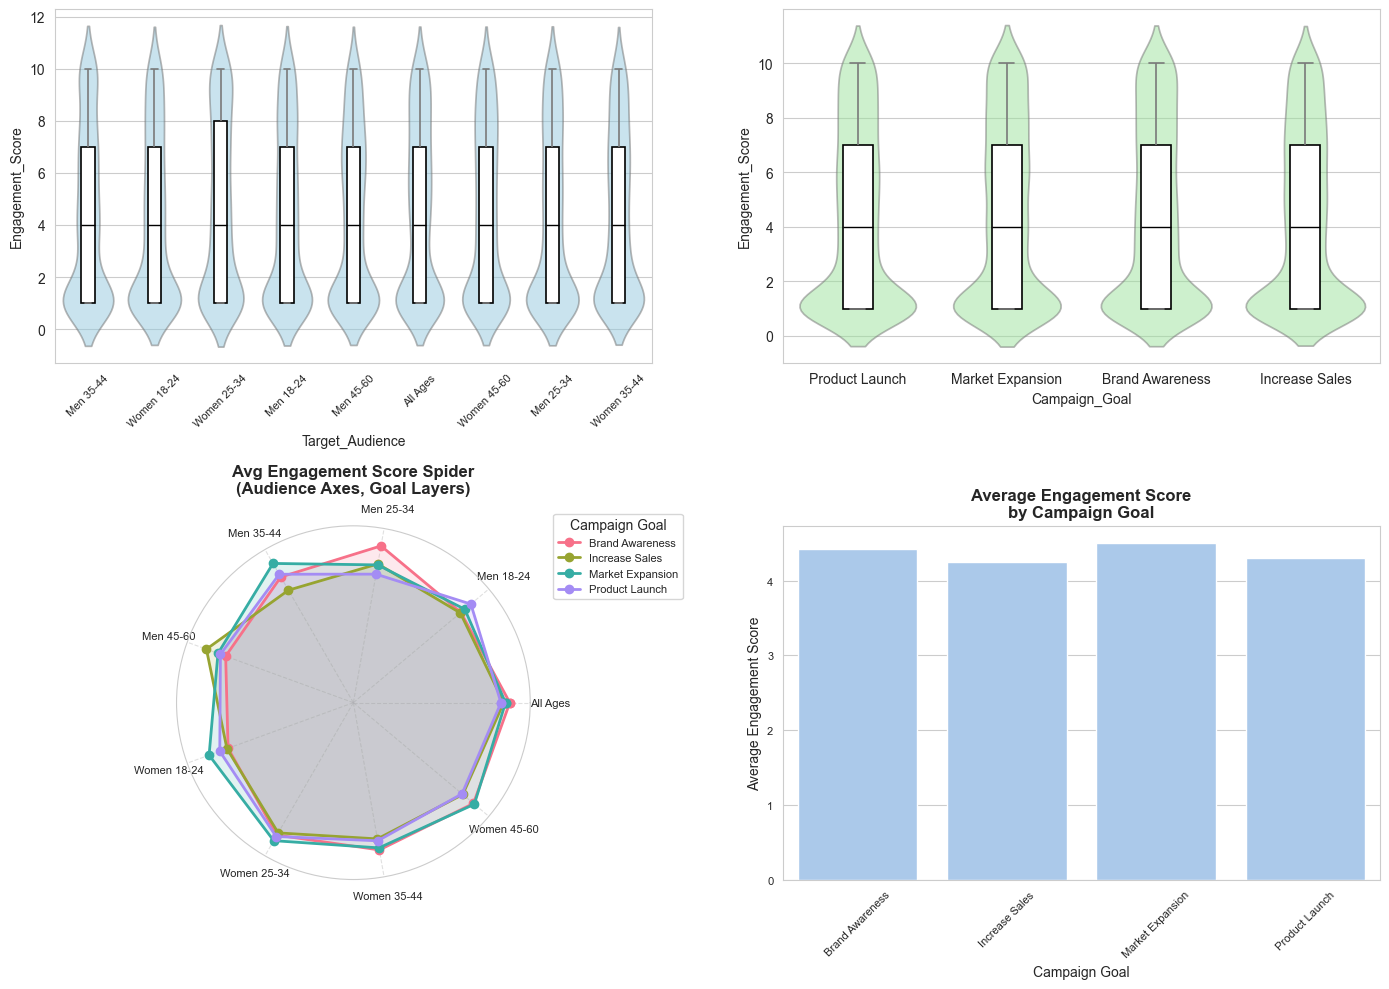

In [24]:
pivot_avg_engagement = df.pivot_table(
    values='Engagement_Score',
    index='Target_Audience',
    columns='Campaign_Goal',
    aggfunc='mean'
)

pivot_avg_engagement_filled = pivot_avg_engagement.fillna(0)

goal_avg_engagement_simple = df.groupby('Campaign_Goal')['Engagement_Score'].mean().reset_index()

fig = plt.figure(figsize=(14, 10))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

target_audience_labels = pivot_avg_engagement_filled.index.tolist()
num_target_audiences = len(target_audience_labels)
campaign_goal_labels = pivot_avg_engagement_filled.columns.tolist()
num_campaign_goals = len(campaign_goal_labels)

if num_target_audiences >= 3:
    ax3 = fig.add_subplot(2, 2, 3, projection='polar')
    angles = [n / float(num_target_audiences) * 2 * np.pi for n in range(num_target_audiences)]
    angles += angles[:1]

    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(target_audience_labels, fontsize=8)
    ax3.set_yticks([])
    ax3.set_title("Avg Engagement Score Spider\n(Audience Axes, Goal Layers)", fontsize=12, weight='bold', va='bottom')
    ax3.grid(True, linestyle='--', alpha=0.6)

    max_value = pivot_avg_engagement_filled.values.max()
    ax3.set_rlim(0, max_value * 1.1)

    colors = sns.color_palette("husl", num_campaign_goals)
    for i, goal in enumerate(campaign_goal_labels):
        values = pivot_avg_engagement_filled[goal].tolist()
        values += values[:1]
        ax3.plot(angles, values, marker='o', linewidth=2, color=colors[i], label=goal)
        ax3.fill(angles, values, color=colors[i], alpha=0.15)

    ax3.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), title='Campaign Goal', fontsize=8)

else:
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.text(0.5, 0.5, f'Not enough Target Audience categories for spider plot\n({num_target_audiences} found, min 3 required)',
             horizontalalignment='center', verticalalignment='center',
             fontsize=10, color='gray', transform=ax3.transAxes)
    ax3.set_title("Avg Engagement Score Spider\n(Audience Axes, Goal Layers)", fontsize=12, weight='bold')
    ax3.axis('off')

ax4 = fig.add_subplot(2, 2, 4)
sns.barplot(x='Campaign_Goal', y='Engagement_Score', data=goal_avg_engagement_simple, ax=ax4)
ax4.set_title("Average Engagement Score\nby Campaign Goal", fontsize=12, weight='bold')
ax4.set_xlabel("Campaign Goal", fontsize=10)
ax4.set_ylabel("Average Engagement Score", fontsize=10)
ax4.tick_params(axis='x', rotation=45, labelsize=8)
ax4.tick_params(axis='y', labelsize=8)

sns.violinplot(
    x='Target_Audience', y='Engagement_Score',
    data=df, inner=None, alpha=0.5, color='skyblue', ax=ax1, zorder=1
)
sns.boxplot(
    x='Target_Audience', y='Engagement_Score', data=df,
    width=0.2,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.2),
    medianprops=dict(color='black'),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(marker='o', markersize=3, alpha=0.3),
    zorder=3, ax=ax1
)

ax1.tick_params(axis='x', rotation=45, labelsize=8)

sns.violinplot(
    x='Campaign_Goal', y='Engagement_Score',
    data=df, inner=None, alpha=0.5, color='lightgreen', ax=ax2, zorder=1
)
sns.boxplot(
    x='Campaign_Goal', y='Engagement_Score', data=df,
    width=0.2,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.2),
    medianprops=dict(color='black'),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    flierprops=dict(marker='o', markersize=3, alpha=0.3),
    zorder=3, ax=ax2
)

plt.tight_layout()
plt.savefig("engagement_vs_audience_goal.png", dpi=300)
plt.show()

### Testing for normality of each of the group

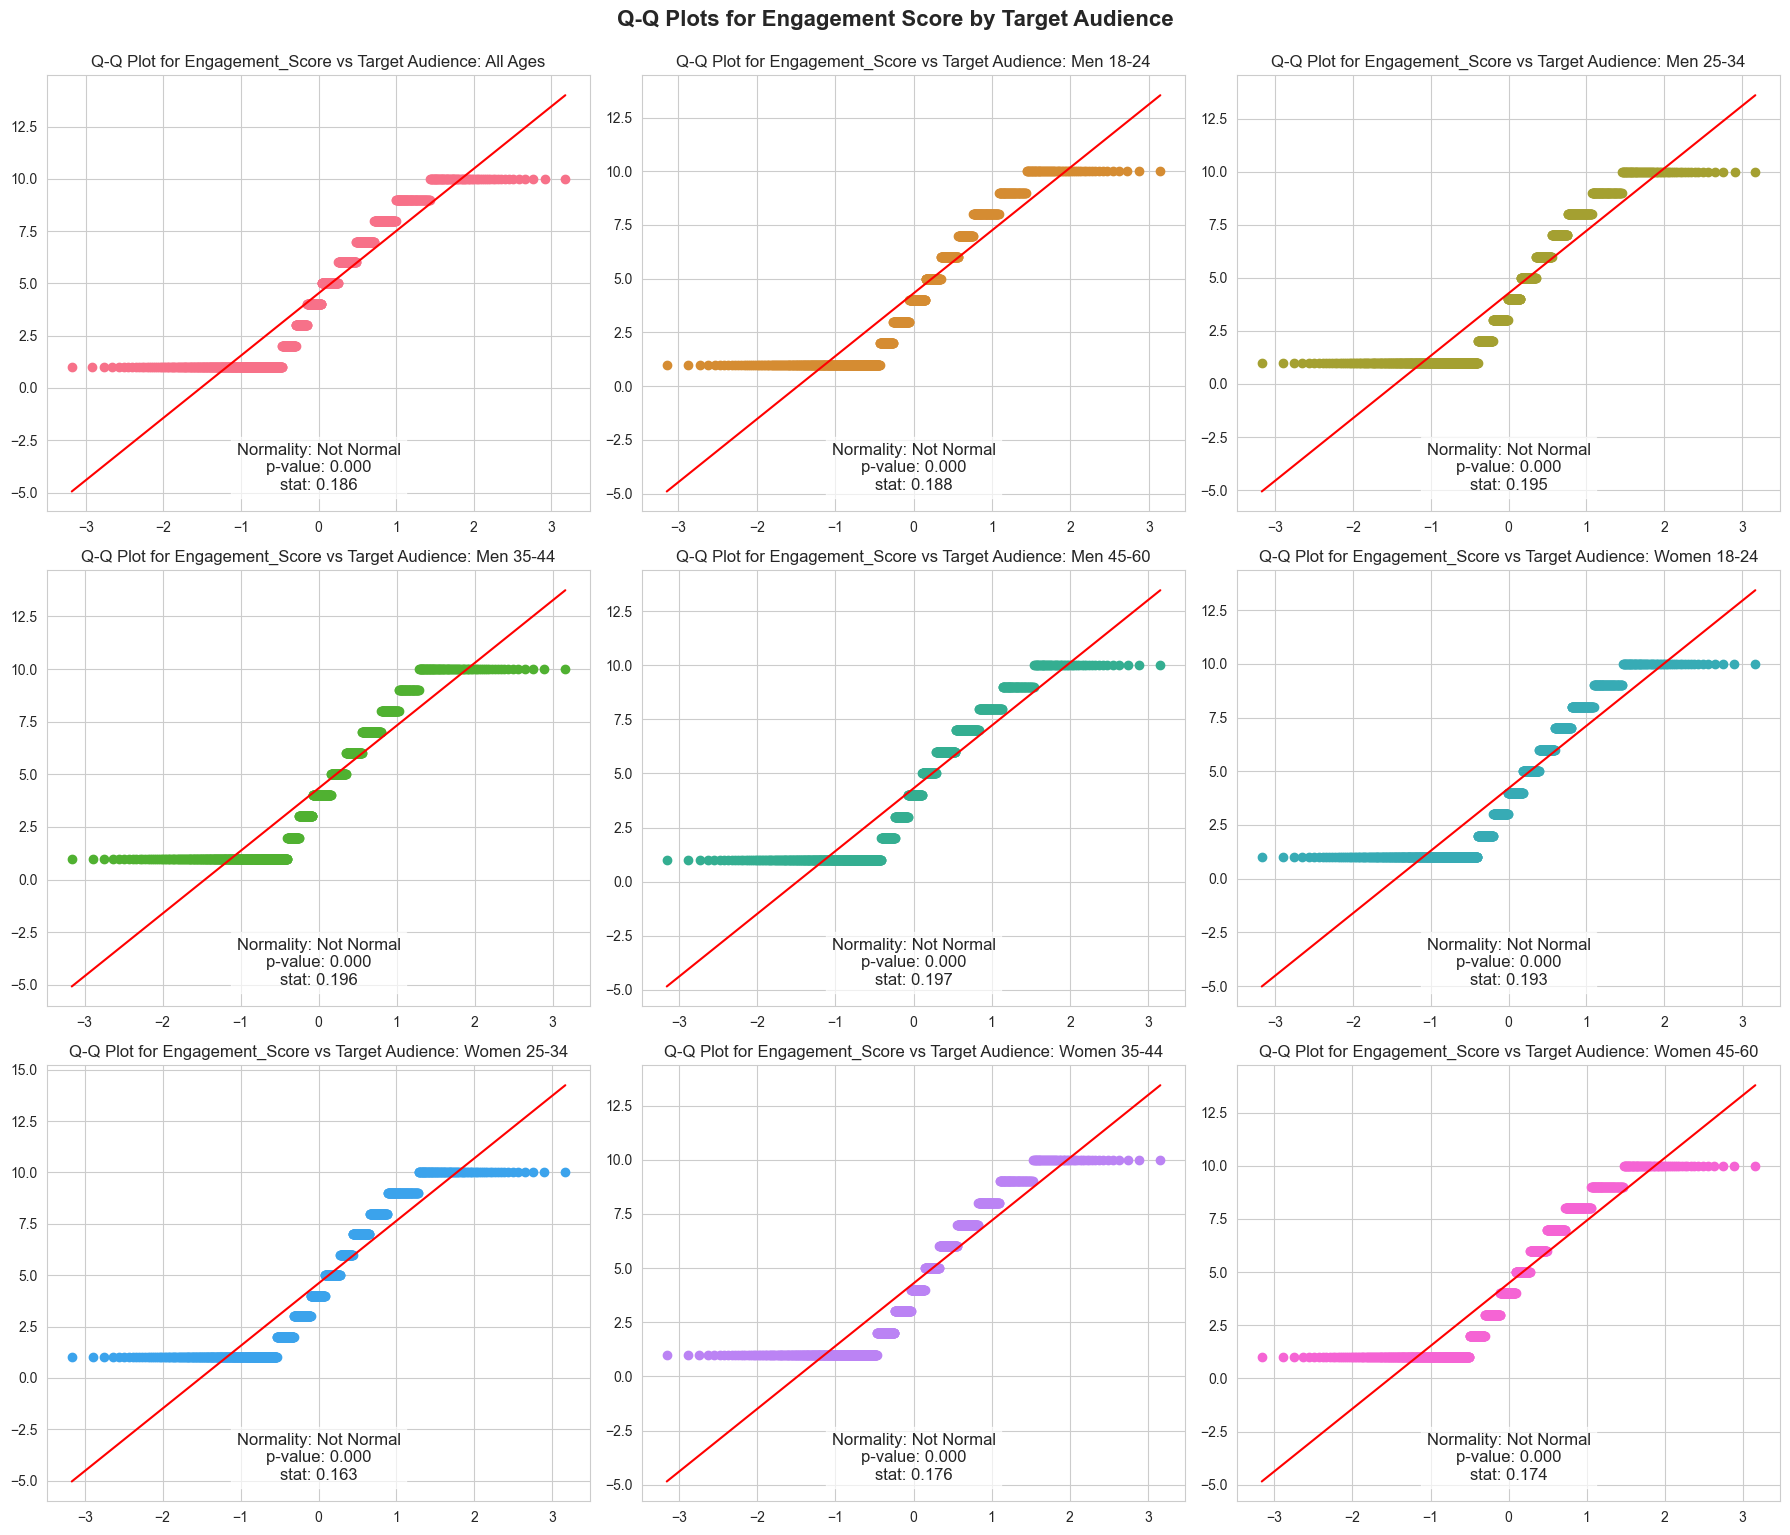

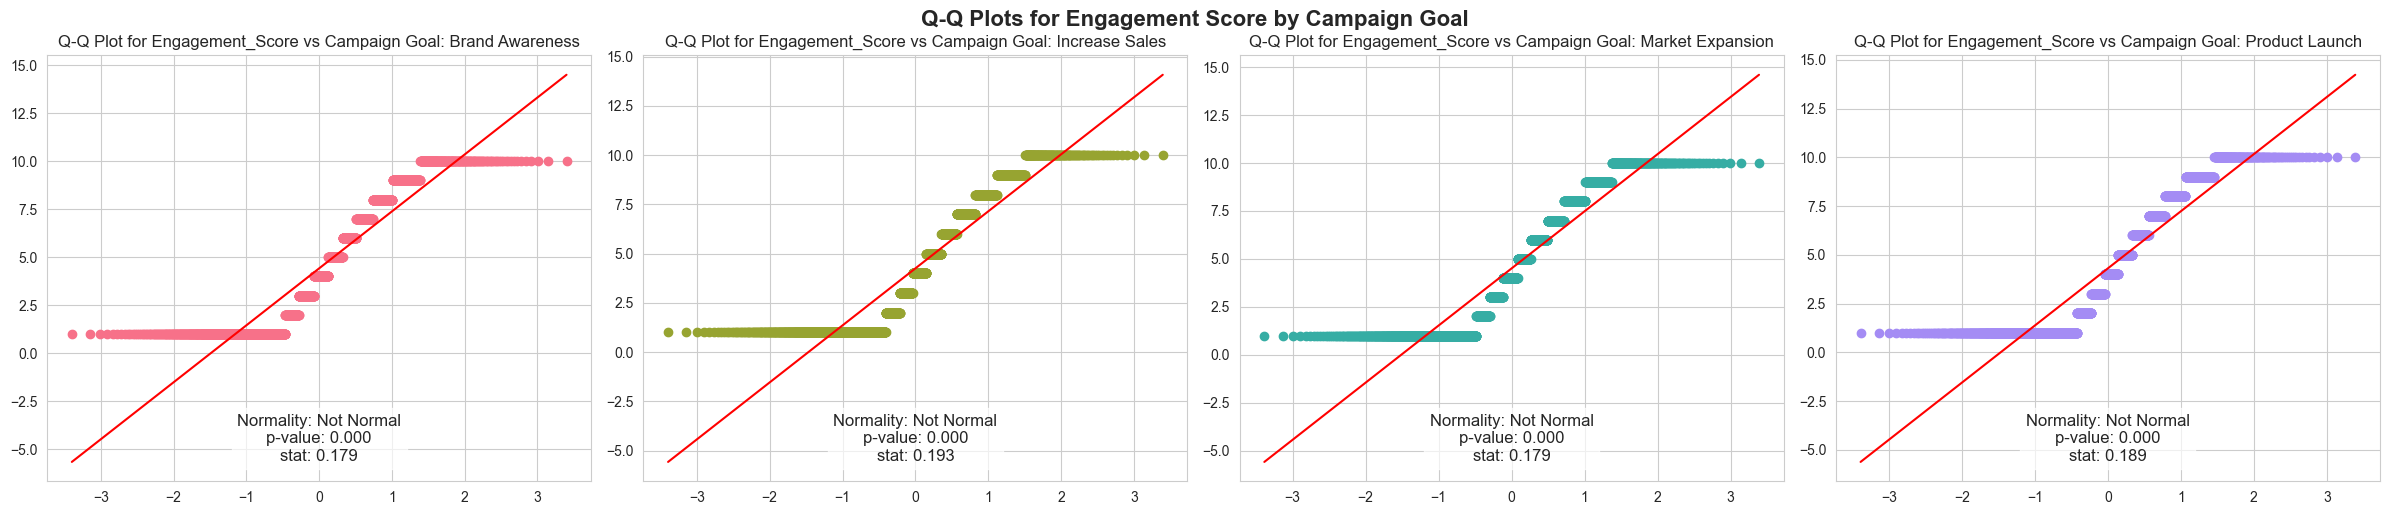

In [25]:
unique_audiences = sorted(df['Target_Audience'].unique())
num_audiences = len(unique_audiences)
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

colors = sns.color_palette("husl", num_audiences)

for i in range(rows * cols):
    if i < num_audiences:
        audience = unique_audiences[i]
        subset = df[df['Target_Audience'] == audience]
        sample = subset['Engagement_Score'].dropna()
        if not sample.empty:
            plot_q_q_plot(sample, axes[i], f"Engagement_Score vs Target Audience: {audience}", color=colors[i])
        else:
            axes[i].set_title(f"No data for {audience}")
            axes[i].axis('off')
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Q-Q Plots for Engagement Score by Target Audience", fontsize=16, weight='bold', y=1.02)
plt.savefig("qq_engagement_vs_target_audience.png", dpi=300)
plt.show()

unique_goals = sorted(df['Campaign_Goal'].unique())
num_goals = len(unique_goals)
rows, cols = 1, 4

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5))
if num_goals == 1:
    axes = [axes]
elif isinstance(axes, np.ndarray):
    axes = axes.flatten()

colors = sns.color_palette("husl", num_goals)

for i in range(rows * cols):
    if i < num_goals:
        goal = unique_goals[i]
        subset = df[df['Campaign_Goal'] == goal]
        sample = subset['Engagement_Score'].dropna()
        if not sample.empty:
            plot_q_q_plot(sample, axes[i], f"Engagement_Score vs Campaign Goal: {goal}", color=colors[i])
        else:
            axes[i].set_title(f"No data for {goal}")
            axes[i].axis('off')
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Q-Q Plots for Engagement Score by Campaign Goal", fontsize=16, weight='bold', y=1.02)
plt.savefig("qq_engagement_vs_campaign_goal.png", dpi=300)
plt.show()

### Testing for homogenity of variance

In [26]:
print(f"\n{styles.BOLD}{styles.FG_MAGENTA}Doing Levene's test for Homogeneity of Variances for Engagement Score based on:{styles.RESET}")

print(f"\n{styles.BOLD}{styles.FG_MAGENTA}TARGET AUDIENCE{styles.RESET}")
audience_groups_engagement = [df[df['Target_Audience'] == audience]['Engagement_Score'].dropna() for audience in unique_audiences]

audience_groups_engagement = [group for group in audience_groups_engagement if not group.empty]

if len(audience_groups_engagement) >= 2:
    levene_test(audience_groups_engagement)
else:
    print(f"{styles.FG_YELLOW}Less than 2 non-empty groups for Target Audience. Levene's test not applicable.{styles.RESET}")

print(f"\n{styles.BOLD}{styles.FG_MAGENTA}CAMPAIGN GOAL{styles.RESET}")
goal_groups_engagement = [df[df['Campaign_Goal'] == goal]['Engagement_Score'].dropna() for goal in unique_goals]

goal_groups_engagement = [group for group in goal_groups_engagement if not group.empty]

if len(goal_groups_engagement) >= 2:
    levene_test(goal_groups_engagement)
else:
    print(f"{styles.FG_YELLOW}Less than 2 non-empty groups for Campaign Goal. Levene's test not applicable.{styles.RESET}")


Doing Levene's test for Homogeneity of Variances for Engagement Score based on:

TARGET AUDIENCE
	Statistic: 0.8168, p-value: 0.5876
	✔ The variances are homogenous (fail to reject the null hypothesis).

CAMPAIGN GOAL
	Statistic: 0.7200, p-value: 0.5399
	✔ The variances are homogenous (fail to reject the null hypothesis).


### Doing Kruskal-Wallis Test as data is !Normal + Homogenous

In [27]:
print(f"\n{styles.BOLD}{styles.FG_YELLOW}Kruskal-Wallis Test: Engagement Score vs Target Audience{styles.RESET}")

if len(audience_groups_engagement) >= 2:
    kruskal_engagement_audience = stats.kruskal(*audience_groups_engagement)
    print(f"{styles.FG_YELLOW}p-value: {kruskal_engagement_audience.pvalue:.4f}{styles.RESET}")

    if kruskal_engagement_audience.pvalue < 0.05:
        print(f"\n{styles.FG_MAGENTA}{styles.BOLD}Significant difference found! Pairwise Mann-Whitney U tests for Engagement Score based on Target Audience:{styles.RESET}")

        non_empty_unique_audiences = [unique_audiences[i] for i, group in enumerate([df[df['Target_Audience'] == audience]['Engagement_Score'].dropna() for audience in unique_audiences]) if not group.empty]

        for i in range(len(non_empty_unique_audiences)):
            for j in range(i + 1, len(non_empty_unique_audiences)):
                g1 = audience_groups_engagement[i]
                g2 = audience_groups_engagement[j]
                stat, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
                color = styles.FG_GREEN if p > 0.05 else styles.FG_RED
                result_text = "No significant difference" if p > 0.05 else "Significant difference"
                print(f"{color}→ {non_empty_unique_audiences[i]} vs {non_empty_unique_audiences[j]} | p-value: {p:.4f} ({result_text}){styles.RESET}")

    else:
        print(f"{styles.FG_GREEN}✔ No statistically significant difference in Engagement Score across Target Audiences.{styles.RESET}")
else:
     print(f"{styles.FG_YELLOW}Less than 2 non-empty groups for Target Audience. Kruskal-Wallis test not applicable.{styles.RESET}")


print(f"\n{styles.BOLD}{styles.FG_YELLOW}Kruskal-Wallis Test: Engagement Score vs Campaign Goal{styles.RESET}")

if len(goal_groups_engagement) >= 2:
    kruskal_engagement_goal = stats.kruskal(*goal_groups_engagement)
    print(f"{styles.FG_YELLOW}p-value: {kruskal_engagement_goal.pvalue:.4f}{styles.RESET}")

    if kruskal_engagement_goal.pvalue < 0.05:
        print(f"\n{styles.FG_MAGENTA}{styles.BOLD}Significant difference found! Pairwise Mann-Whitney U tests for Engagement Score based on Campaign Goal:{styles.RESET}")

        non_empty_unique_goals = [unique_goals[i] for i, group in enumerate([df[df['Campaign_Goal'] == goal]['Engagement_Score'].dropna() for goal in unique_goals]) if not group.empty]

        for i in range(len(non_empty_unique_goals)):
            for j in range(i + 1, len(non_empty_unique_goals)):
                g1 = goal_groups_engagement[i]
                g2 = goal_groups_engagement[j]
                stat, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
                color = styles.FG_GREEN if p > 0.05 else styles.FG_RED
                result_text = "No significant difference" if p > 0.05 else "Significant difference"
                print(f"{color}→ {non_empty_unique_goals[i]} vs {non_empty_unique_goals[j]} | p-value: {p:.4f} ({result_text}){styles.RESET}")
    else:
        print(f"{styles.FG_GREEN}✔ No statistically significant difference in Engagement Score across Campaign Goals.{styles.RESET}")
else:
    print(f"{styles.FG_YELLOW}Less than 2 non-empty groups for Campaign Goal. Kruskal-Wallis test not applicable.{styles.RESET}")


Kruskal-Wallis Test: Engagement Score vs Target Audience
p-value: 0.1230
✔ No statistically significant difference in Engagement Score across Target Audiences.

Kruskal-Wallis Test: Engagement Score vs Campaign Goal
p-value: 0.0529
✔ No statistically significant difference in Engagement Score across Campaign Goals.


### 📊 **Effect of Target Audience and Campaign Goal on User Engagement Scores**

---

#### 🧪 **Tests Summary**

| **Test** | **Result** | **p-value** | **Conclusion** |
| :----------------------------------------- | :--------- | :---------- | :---------------------------------------------------- |
| **Normality Test (Groups)** | ❌ Failed  | N/A         | None of the groups are normally distributed           |
| **Levene’s Test (Target Audience)** | ✅ Passed  | 0.5876      | Variances are homogenous                              |
| **Levene’s Test (Campaign Goal)** | ✅ Passed  | 0.5399      | Variances are homogenous                              |
| **Kruskal-Wallis Test (Target Audience)** | ❌ Failed  | 0.1230      | No significant difference exists between groups (p > 0.05) |
| **Kruskal-Wallis Test (Campaign Goal)** | ❌ Failed  | 0.0529      | No significant difference exists between groups (p > 0.05) |

---

### 🔍 **Final Conclusion**

📌 Based on non-parametric statistical analysis (Kruskal-Wallis):

- Non-parametric tests were used because the engagement scores were **not normally distributed** across any of the groups.
- **Levene's Test** indicated that the variances of engagement scores were **homogenous** across groups for both **Target Audience** and **Campaign Goal**, satisfying a condition for the Kruskal-Wallis test.
- The **Kruskal-Wallis Test** for **Target Audience** (p-value: 0.1230 > 0.05) indicates **no statistically significant difference** in engagement scores based on the target audience.
- The **Kruskal-Wallis Test** for **Campaign Goal** (p-value: 0.0529 > 0.05) also indicates **no statistically significant difference** in engagement scores based on the campaign goal.

Therefore, based on this analysis, neither the **Target Audience** nor the **Campaign Goal**, as defined in this dataset, appear to have a statistically significant impact on **Engagement Scores**. The average engagement score does not significantly differ between different target audiences or different campaign goals.

## Q5 Which factors predict Return on Investment (ROI)?

### Data Visualisation

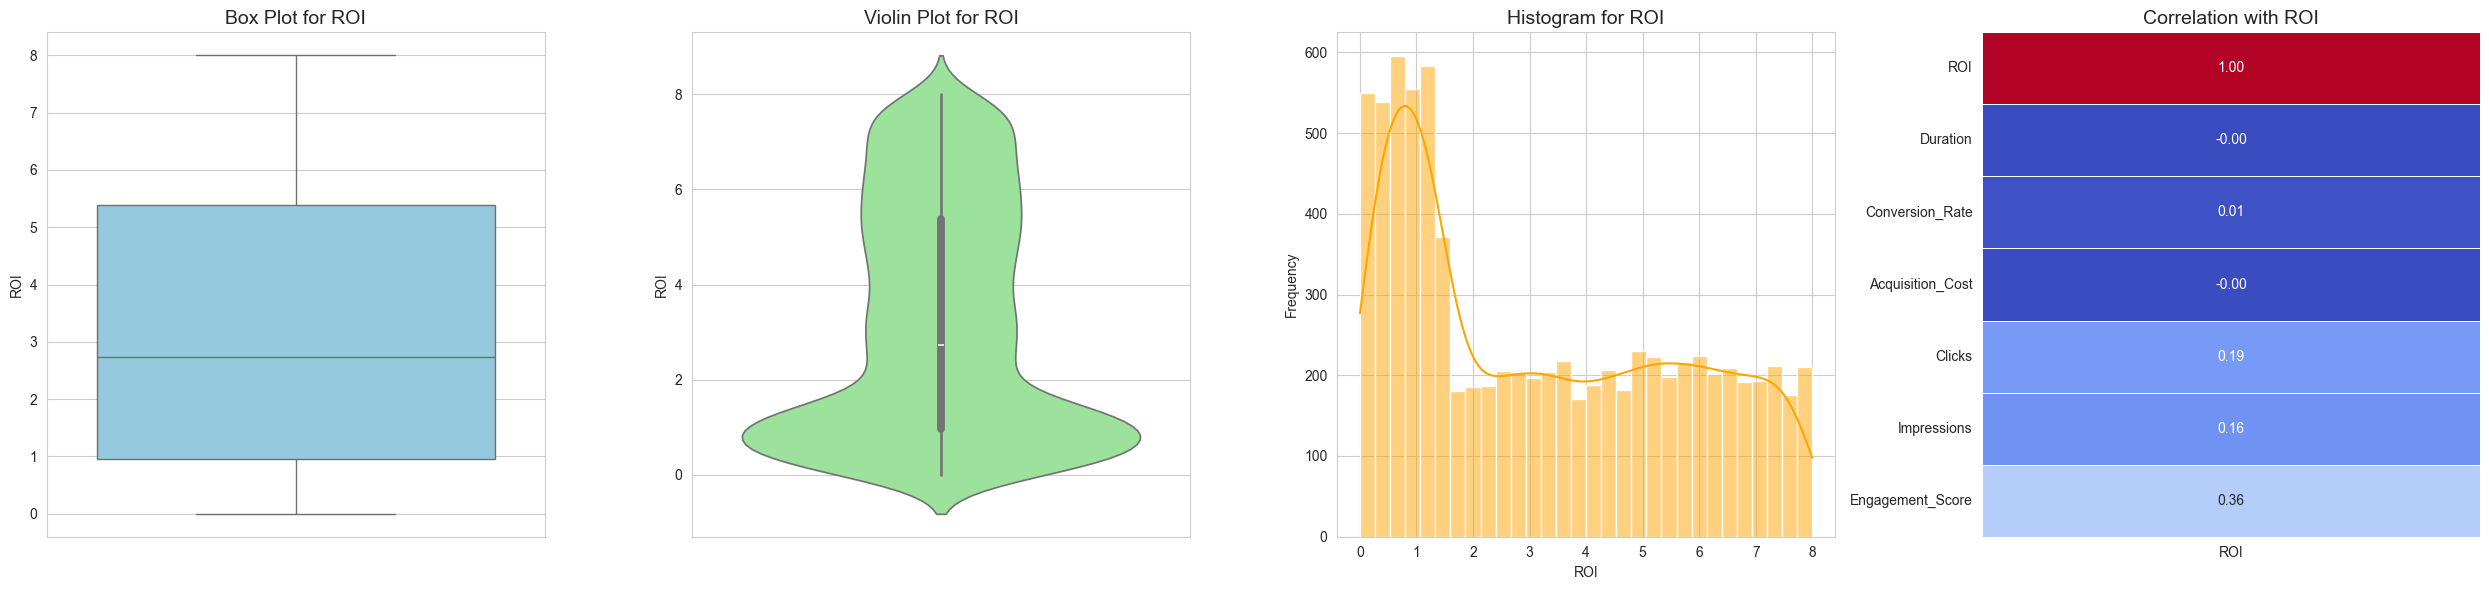

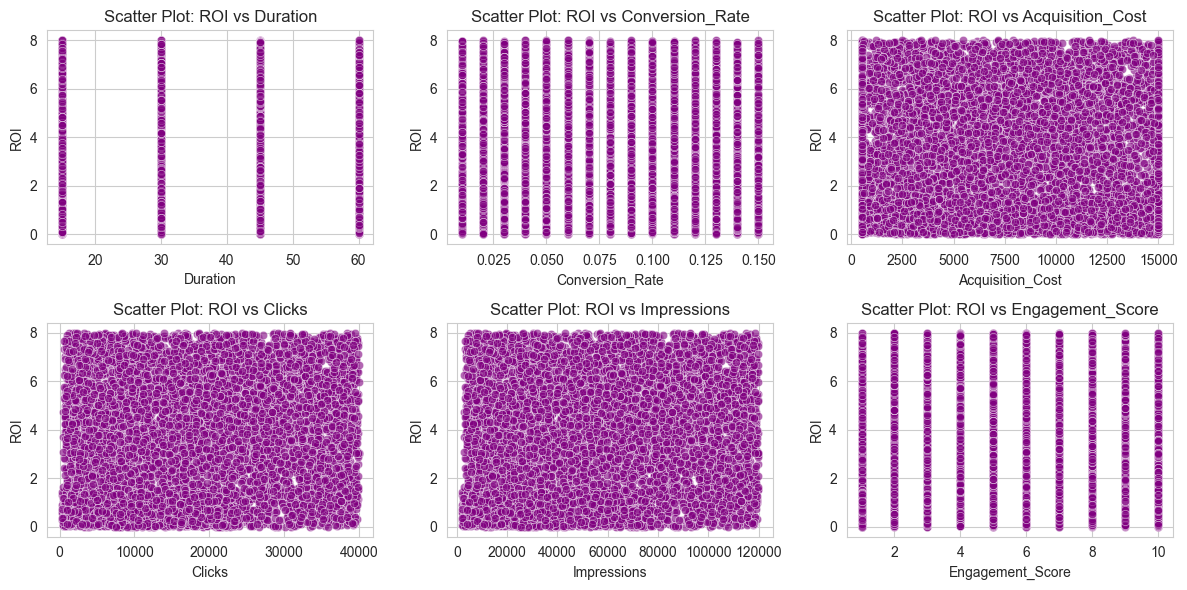

In [28]:
try:
    df['Duration'] = df['Duration'].str.extract('(\d+)').astype(float)
except Exception as e:
    pass

# Create a figure with 1 row and 4 columns for subplots
fig, axes = plt.subplots(1, 4, figsize=(25, 6))

# Box plot for ROI
sns.boxplot(y='ROI', data=df, color='skyblue', ax=axes[0])
axes[0].set_title('Box Plot for ROI', fontsize=14)
axes[0].set_ylabel('ROI')

# Violin plot for ROI
sns.violinplot(y='ROI', data=df, color='lightgreen', ax=axes[1])
axes[1].set_title('Violin Plot for ROI', fontsize=14)
axes[1].set_ylabel('ROI')

# Histogram for ROI
sns.histplot(df['ROI'], bins=30, kde=True, color='orange', ax=axes[2])
axes[2].set_title('Histogram for ROI', fontsize=14)
axes[2].set_xlabel('ROI')
axes[2].set_ylabel('Frequency')

# Numeric columns for correlation with ROI
numeric_cols = ['Duration', 'Conversion_Rate', 'Acquisition_Cost', 'Clicks', 'Impressions', 'Engagement_Score']

# Correlation between ROI and other numerical variables
correlation_with_roi = df[['ROI'] + numeric_cols].corr().loc['ROI']
sns.heatmap(correlation_with_roi.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axes[3], cbar=False)
axes[3].set_title('Correlation with ROI', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.savefig("roi_dataivz.png", dpi=300)
plt.show()

# Scatter plots between ROI and all other numerical variables
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.scatterplot(x=df[col], y=df['ROI'], ax=axes[i], color='purple', alpha=0.6)
    axes[i].set_title(f'Scatter Plot: ROI vs {col}', fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('ROI')

plt.tight_layout()
plt.show()

### VIF Feature Reduction

In [29]:
def calculate_vif(X):
    X_with_const = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    return vif_data

def reduce_vif(X, threshold=15):
    print("\n=== VIF-based Feature Selection ===")
    print("Starting VIF elimination process...")
    X_reduced = X.copy()
    
    while True:
        # Calculate VIF for current features
        vif_data = calculate_vif(X_reduced)
        
        # Get maximum VIF (excluding constant)
        max_vif = vif_data.loc[vif_data['Variable'] != 'const', 'VIF'].max()
        feature_with_max_vif = vif_data.loc[vif_data['VIF'] == max_vif, 'Variable'].values[0]
        
        print(f"Max VIF: {max_vif} for feature {feature_with_max_vif}")
        
        # If max VIF is below threshold, we're done
        if max_vif < threshold:
            print("All VIFs are below threshold, stopping elimination")
            break
        
        # Otherwise, remove the feature with highest VIF
        print(f"Removing {feature_with_max_vif} with VIF: {max_vif}")
        X_reduced = X_reduced.drop(feature_with_max_vif, axis=1)
        
    # Display final VIF values
    final_vif = calculate_vif(X_reduced)
    print("\nFinal VIF values:")
    print(final_vif.sort_values('VIF', ascending=False))
    
    return X_reduced

def evaluate_model(X, y, model_name="Model"):
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()
    
    print(f"\n=== {model_name} Summary ===")
    print(model.summary())
    
    # Calculate and return metrics for comparison
    return {
        "name": model_name,
        "r_squared": model.rsquared,
        "adj_r_squared": model.rsquared_adj,
        "aic": model.aic,
        "bic": model.bic,
        "num_features": len(X.columns),
        "features": list(X.columns)
    }

In [30]:
df = pd.read_csv("sampled_data.csv")

# Data Preprocessing
df['Acquisition_Cost'] = df['Acquisition_Cost'].str.replace('$', '').astype(float)
df['Duration'] = df['Duration'].str.extract('(\d+)').astype(int)
df = df.drop('Date', axis=1)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Campaign_ID' in numeric_cols:
    numeric_cols.remove('Campaign_ID')

X = df[numeric_cols].drop('ROI', axis=1)
y = df['ROI']

X_with_const = sm.add_constant(X)

X_vif_reduced = reduce_vif(X, threshold=15)
vif_model_metrics = evaluate_model(X_vif_reduced, y, "VIF Model")


=== VIF-based Feature Selection ===
Starting VIF elimination process...
Max VIF: 50613.833361870034 for feature Impressions
Removing Impressions with VIF: 50613.833361870034
Max VIF: 22.85847008957904 for feature Acquisition_Cost
Removing Acquisition_Cost with VIF: 22.85847008957904
Max VIF: 6.643896945408754 for feature Clicks
All VIFs are below threshold, stopping elimination

Final VIF values:
           Variable        VIF
0             const  14.302846
3            Clicks   6.643897
1          Duration   6.348047
4  Engagement_Score   1.263444
2   Conversion_Rate   1.000628

=== VIF Model Summary ===
                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     569.6
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           

### Checking Regression assumption and visualising result


=== Checking Regression Assumptions for VIF-Reduced Model ===


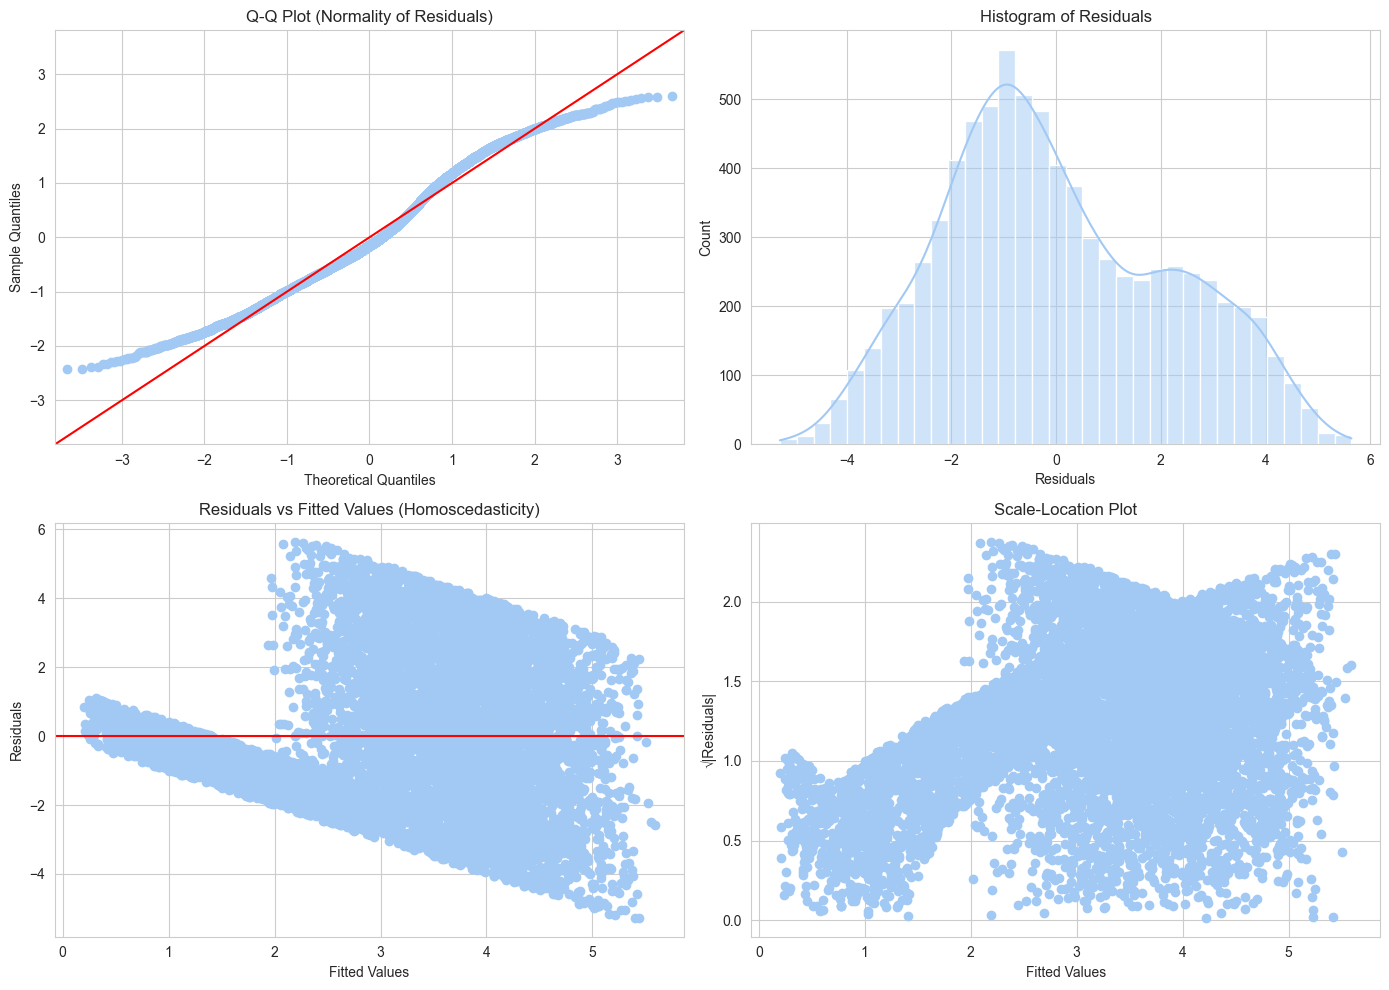

Shapiro-Wilk Test for Normality: statistic=0.9795, p-value=0.0000
Residuals are not normally distributed (p < 0.05)
Breusch-Pagan Test for Homoscedasticity: statistic=625.0105, p-value=0.0000
Heteroscedasticity detected (p < 0.05)


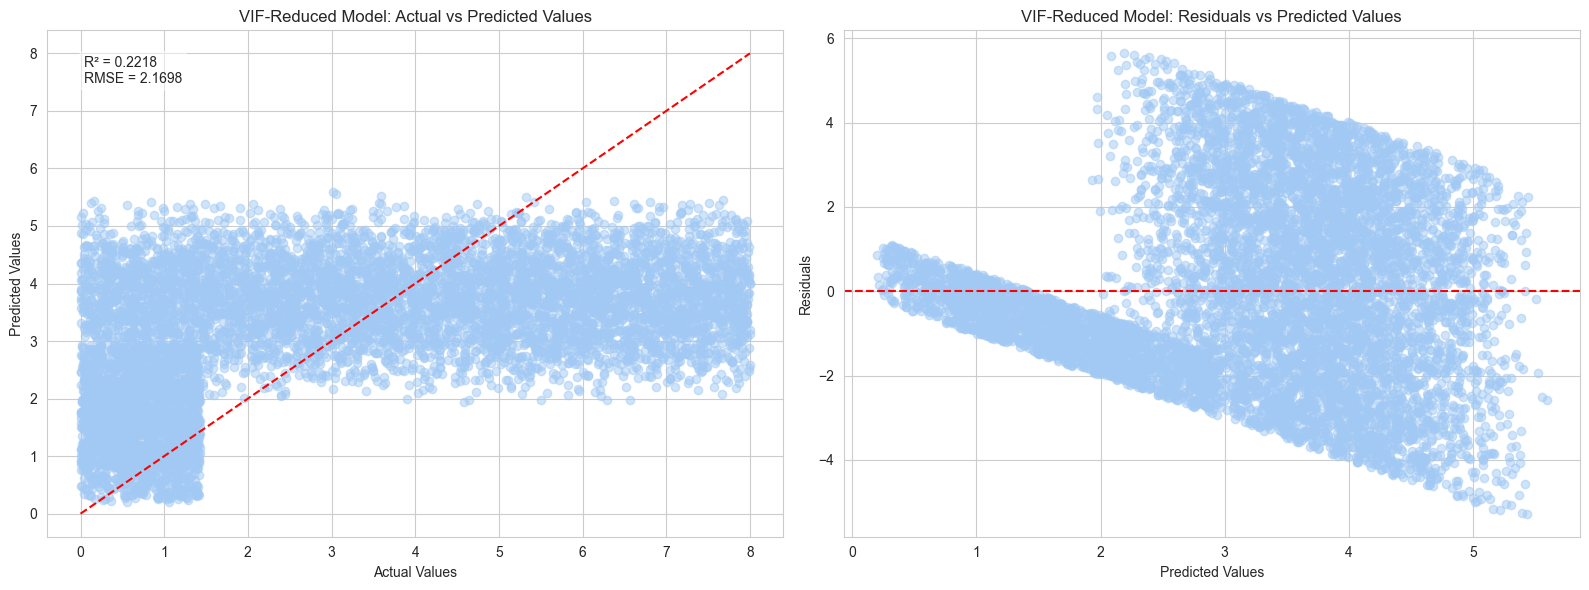

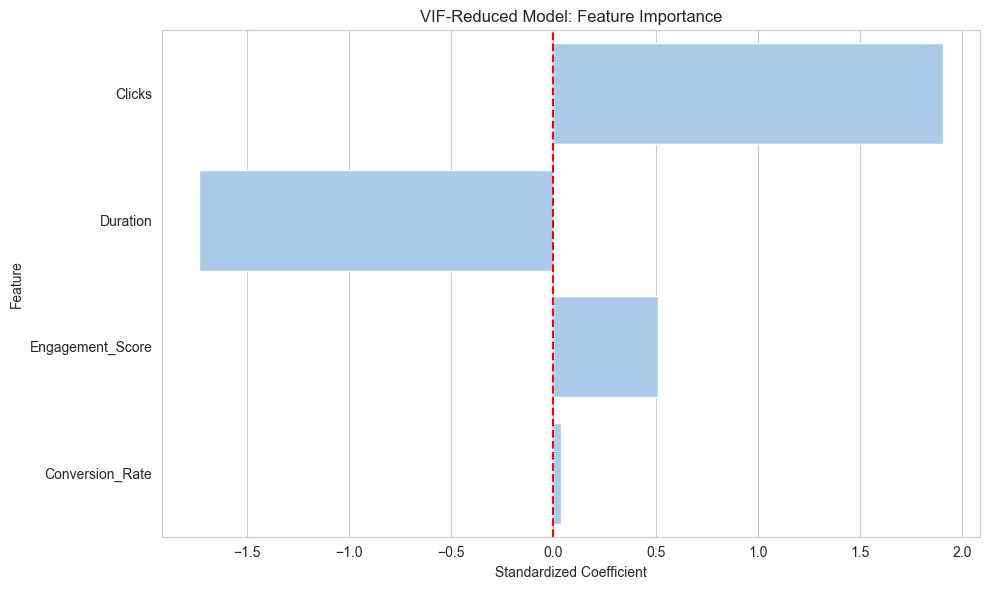


=== VIF-Reduced Model Prediction Metrics ===
R² Score: 0.2218
Mean Squared Error: 4.7082
Root Mean Squared Error: 2.1698
Mean Absolute Error: 1.7893


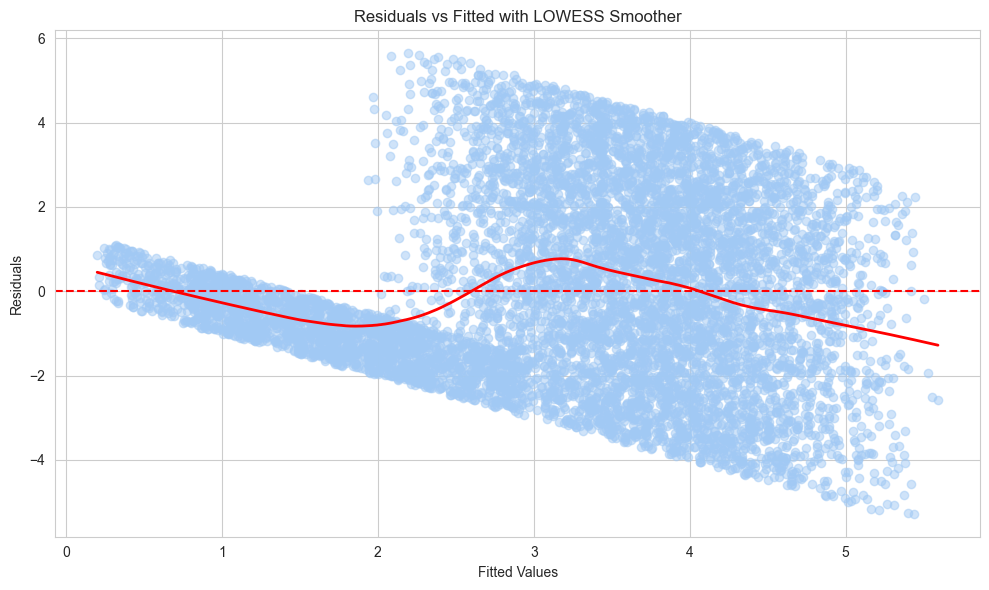

In [31]:
def check_regression_assumptions(X, y, model_name="Model"):
    print(f"\n=== Checking Regression Assumptions for {model_name} ===")
    
    # Fit the model
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()
    
    # Get residuals
    residuals = model.resid
    fitted_values = model.fittedvalues
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Q-Q Plot (Normality of residuals)
    sm.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=axes[0, 0])
    axes[0, 0].set_title('Q-Q Plot (Normality of Residuals)')
    
    # 2. Residuals Histogram with normal curve
    sns.histplot(residuals, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residuals')
    
    # 3. Residuals vs Fitted values (Homoscedasticity)
    axes[1, 0].scatter(fitted_values, residuals)
    axes[1, 0].axhline(y=0, color='r', linestyle='-')
    axes[1, 0].set_title('Residuals vs Fitted Values (Homoscedasticity)')
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('Residuals')
    
    # 4. Scale-Location Plot (Homoscedasticity)
    sqrt_abs_resid = np.sqrt(np.abs(residuals))
    axes[1, 1].scatter(fitted_values, sqrt_abs_resid)
    axes[1, 1].set_title('Scale-Location Plot')
    axes[1, 1].set_xlabel('Fitted Values')
    axes[1, 1].set_ylabel('√|Residuals|')
    
    plt.tight_layout()
    plt.savefig(f"multireg_diagnostic_plots.png", dpi=300)
    plt.show()
    
    # Statistical test for normality
    stat, p_value = stats.shapiro(residuals)
    print(f"Shapiro-Wilk Test for Normality: statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Residuals are not normally distributed (p < 0.05)")
    else:
        print("Residuals appear to be normally distributed (p >= 0.05)")
    
    # Breusch-Pagan test for homoscedasticity
    bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, X_with_const)
    print(f"Breusch-Pagan Test for Homoscedasticity: statistic={bp_test[0]:.4f}, p-value={bp_test[1]:.4f}")
    if bp_test[1] < 0.05:
        print("Heteroscedasticity detected (p < 0.05)")
    else:
        print("Homoscedasticity assumption is met (p >= 0.05)")
    
    return model

def visualize_predictions(X, y, model_name="Model"):
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()
    
    # Get predictions
    predictions = model.predict(X_with_const)
    
    # Create figure for visualizations
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Predicted vs Actual
    axes[0].scatter(y, predictions, alpha=0.5)
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    axes[0].set_title(f'{model_name}: Actual vs Predicted Values')
    axes[0].set_xlabel('Actual Values')
    axes[0].set_ylabel('Predicted Values')
    
    # Calculate metrics
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, predictions)
    
    # Add metrics annotation
    textstr = f'R² = {r2:.4f}\nRMSE = {rmse:.4f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, 
                fontsize=10, verticalalignment='top', bbox=props)
    
    # Plot 2: Residuals vs Predicted
    axes[1].scatter(predictions, y - predictions, alpha=0.5)
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_title(f'{model_name}: Residuals vs Predicted Values')
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals')
    
    plt.tight_layout()
    plt.savefig("multireg_predictions.png", dpi=300)
    plt.show()
    
    # Feature importance (based on standardized coefficients)
    X_scaled = (X - X.mean()) / X.std()
    X_scaled_with_const = sm.add_constant(X_scaled)
    model_scaled = sm.OLS(y, X_scaled_with_const).fit()
    
    # Create DataFrame for feature importance
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Standardized Coefficient': model_scaled.params[1:],
        'Absolute Coefficient': np.abs(model_scaled.params[1:])
    })
    importance = importance.sort_values('Absolute Coefficient', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Standardized Coefficient', y='Feature', data=importance)
    plt.title(f'{model_name}: Feature Importance')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.savefig("multireg_feature_importance.png", dpi=300)
    plt.show()
    
    # Print prediction metrics
    print(f"\n=== {model_name} Prediction Metrics ===")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y, predictions):.4f}")
    
    return model, importance

# Check regression assumptions
vif_model = check_regression_assumptions(X_vif_reduced, y, "VIF-Reduced Model")

# Visualize predictions vs actual values
vif_model, feature_importance = visualize_predictions(X_vif_reduced, y, "VIF-Reduced Model")

# Bonus: Create a residual plot with LOWESS smoother to check for patterns
plt.figure(figsize=(10, 6))
residuals = vif_model.resid
fitted = vif_model.fittedvalues

plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')

# Add a LOWESS smoother to check for patterns in the residuals
lowess = sm.nonparametric.lowess(residuals, fitted, frac=0.3)
plt.plot(lowess[:, 0], lowess[:, 1], color='red', lw=2)

plt.title('Residuals vs Fitted with LOWESS Smoother')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.tight_layout()
plt.savefig("multireg_residuals_lowess.png", dpi=300)
plt.show()

### Results and Conclusion

We performed a multiple linear regression analysis to investigate whether various campaign-level features could predict Return on Investment (ROI). Prior to modeling, we visualized the data and observed that ROI exhibited weak correlation with all independent variables. This raised early concerns about the predictive power of the regression model.

To mitigate multicollinearity and retain only the most informative features, we conducted a Variance Inflation Factor (VIF) analysis. Features with excessively high VIF values (e.g., `Impressions` and `Acquisition_Cost`) were iteratively removed until all remaining predictors had acceptable VIF scores, ensuring a more stable regression model.

### Assumption Checks

| Assumption           | Method                          | Result                     | Conclusion                             |
|----------------------|----------------------------------|-----------------------------|-----------------------------------------|
| **Normality**        | Shapiro-Wilk Test               | *p* < 0.05                  | Residuals are not normally distributed  |
| **Homoscedasticity** | Breusch-Pagan Test              | *p* < 0.05                  | Heteroscedasticity is present           |
| **Linearity**        | Residual plots                  | Patterns observed           | Potential non-linearity                 |

These diagnostics indicate violations of key assumptions required for valid inference from linear regression.

### Model Performance

| Metric                          | Value     |
|----------------------------------|-----------|
| **R² Score**                     | 0.2218    |
| **Mean Squared Error (MSE)**     | 4.7082    |
| **Root Mean Squared Error (RMSE)** | 2.1698    |
| **Mean Absolute Error (MAE)**     | 1.7893    |

As shown in the predictions vs. actual values plot, the model struggled to capture meaningful trends or patterns in ROI. Additionally, the feature importance plot and LOWESS-smoothed residuals further confirmed poor model generalization.

### Conclusion

Based on the model's low predictive power and the violation of fundamental regression assumptions, we fail to reject the null hypothesis ($H_0$). This implies that there is no statistically significant linear relationship between ROI and the chosen set of independent variables. Hence, the results obtained from this regression model are not reliable for making valid inferences or predictions regarding ROI.

## Q6 Does duration of campaign have any effect on impressions?

### Visualising data

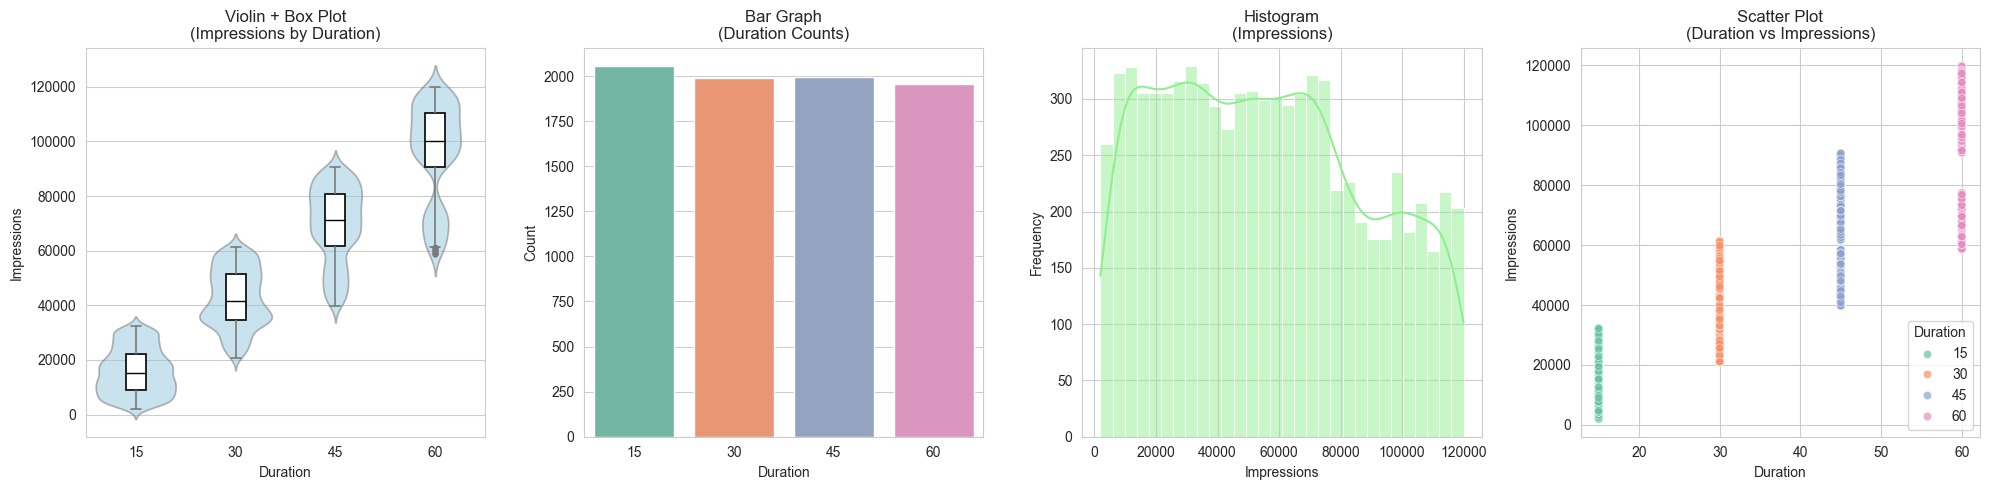

In [32]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the figure size and layout
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Box inside Violin plot for each duration category on impression data
sns.violinplot(
    x='Duration', y='Impressions', data=df, inner=None, alpha=0.5, color='skyblue', ax=axes[0]
)
sns.boxplot(
    x='Duration', y='Impressions', data=df, width=0.2, boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.2),
    medianprops=dict(color='black'), whiskerprops=dict(linewidth=1.2), capprops=dict(linewidth=1.2),
    flierprops=dict(marker='o', markersize=3, alpha=0.3), zorder=3, ax=axes[0]
)
axes[0].set_title("Violin + Box Plot\n(Impressions by Duration)", fontsize=12)
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Impressions")

# Bar graph for duration
duration_counts = df['Duration'].value_counts()
sns.barplot(x=duration_counts.index, y=duration_counts.values, palette='Set2', ax=axes[1])
axes[1].set_title("Bar Graph\n(Duration Counts)", fontsize=12)
axes[1].set_xlabel("Duration")
axes[1].set_ylabel("Count")

# Histogram for impressions data
sns.histplot(df['Impressions'], bins=30, kde=True, color='lightgreen', ax=axes[2])
axes[2].set_title("Histogram\n(Impressions)", fontsize=12)
axes[2].set_xlabel("Impressions")
axes[2].set_ylabel("Frequency")

# Scatter plot between duration and impressions
sns.scatterplot(x='Duration', y='Impressions', data=df, hue='Duration', palette='Set2', ax=axes[3], alpha=0.7)
axes[3].set_title("Scatter Plot\n(Duration vs Impressions)", fontsize=12)
axes[3].set_xlabel("Duration")
axes[3].set_ylabel("Impressions")
axes[3].legend(title="Duration", loc='lower right')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("duration_impressions_visualization.png", dpi=300)
plt.show()

### Permutation Test

Observed Statistic (Between-group variance): 7170164280095.576
Permutation Test p-value: 0.0


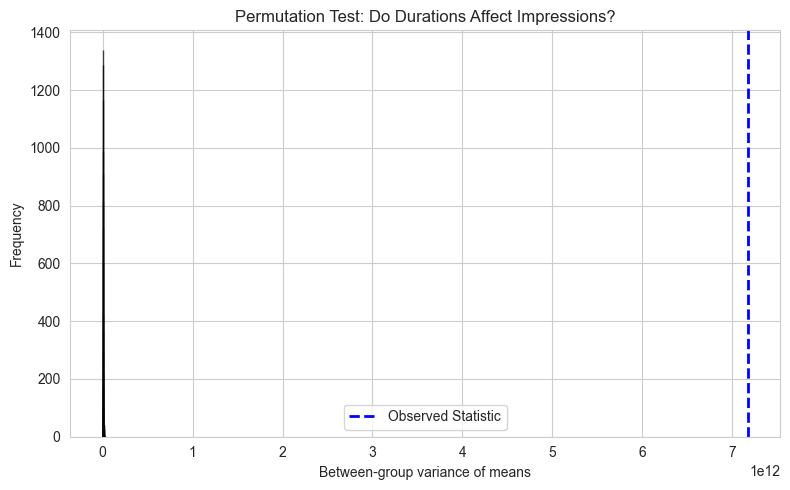

In [33]:
df = pd.read_csv("sampled_data.csv")  # replace with actual path

# Clean up Duration
df['Duration'] = df['Duration'].str.strip()

# Grouped data
duration_groups = df.groupby('Duration')['Impressions'].apply(np.array)

# Store group names and sizes
group_names = duration_groups.index.tolist()
group_arrays = [duration_groups[dur] for dur in group_names]
group_sizes = [len(arr) for arr in group_arrays]

# Observed statistic: variance of group means
group_means = [np.mean(g) for g in group_arrays]
overall_mean = np.mean(np.concatenate(group_arrays))
obs_stat = np.sum([(len(g) * (np.mean(g) - overall_mean)**2) for g in group_arrays])

# Combine all data
combined = np.concatenate(group_arrays)
n_iter = 10000
perm_stats = np.zeros(n_iter)
np.random.seed(42)

for i in range(n_iter):
    np.random.shuffle(combined)
    
    start = 0
    perm_group_means = []
    for size in group_sizes:
        group = combined[start:start + size]
        perm_group_means.append(np.mean(group))
        start += size

    perm_overall_mean = np.mean(combined)
    perm_stats[i] = np.sum([size * (mean - perm_overall_mean) ** 2 for size, mean in zip(group_sizes, perm_group_means)])

p_value = np.mean(perm_stats >= obs_stat)

print("Observed Statistic (Between-group variance):", obs_stat)
print("Permutation Test p-value:", p_value)

plt.figure(figsize=(8, 5))
plt.hist(perm_stats, bins=40, color='lightcoral', edgecolor='black', alpha=0.7)
plt.axvline(obs_stat, color='blue', linestyle='dashed', linewidth=2, label="Observed Statistic")
plt.title("Permutation Test: Do Durations Affect Impressions?")
plt.xlabel("Between-group variance of means")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("permutation_test_duration_impressions.png", dpi=300)
plt.show()

### Pair wise test (Post Hoc Analysis)

In [34]:
from itertools import combinations

durations = df['Duration'].unique()
results = []

for dur1, dur2 in combinations(durations, 2):
    group1 = df[df['Duration'] == dur1]['Impressions'].values
    group2 = df[df['Duration'] == dur2]['Impressions'].values

    obs_diff = np.abs(np.mean(group1) - np.mean(group2))
    combined = np.concatenate([group1, group2])
    
    perm_diffs = []
    for _ in range(10000):
        np.random.shuffle(combined)
        perm1 = combined[:len(group1)]
        perm2 = combined[len(group1):]
        perm_diffs.append(np.abs(np.mean(perm1) - np.mean(perm2)))
    
    p_val = np.mean(np.array(perm_diffs) >= obs_diff)
    results.append({'Group1': dur1, 'Group2': dur2, 'p_value': p_val})

for r in results:
    print(f"Comparison: {r['Group1']} vs {r['Group2']} | p-value: {r['p_value']:.4f}")

Comparison: 30 Days vs 60 Days | p-value: 0.0000
Comparison: 30 Days vs 45 Days | p-value: 0.0000
Comparison: 30 Days vs 15 Days | p-value: 0.0000
Comparison: 60 Days vs 45 Days | p-value: 0.0000
Comparison: 60 Days vs 15 Days | p-value: 0.0000
Comparison: 45 Days vs 15 Days | p-value: 0.0000


### Results after benferroni correction

In [35]:
# Adjust p-values
num_tests = len(results)
for r in results:
    r['p_value_corrected'] = min(r['p_value'] * num_tests, 1.0)
for r in results:
    print(f"Comparison: {r['Group1']} vs {r['Group2']} | p-value (corrected): {r['p_value_corrected']:.4f}")

Comparison: 30 Days vs 60 Days | p-value (corrected): 0.0000
Comparison: 30 Days vs 45 Days | p-value (corrected): 0.0000
Comparison: 30 Days vs 15 Days | p-value (corrected): 0.0000
Comparison: 60 Days vs 45 Days | p-value (corrected): 0.0000
Comparison: 60 Days vs 15 Days | p-value (corrected): 0.0000
Comparison: 45 Days vs 15 Days | p-value (corrected): 0.0000


### Statistical Analysis of Campaign Duration on Impressions

The permutation test revealed a highly significant difference in the number of impressions across varying campaign durations (*p* < 0.0001). Additionally, post hoc pairwise permutation tests—adjusted using the conservative Bonferroni correction for multiple comparisons—show that the mean number of impressions differs significantly between each pair of campaign durations (15, 30, 45, and 60 days). 

As a result, we reject the null hypothesis and conclude that campaign duration has a statistically significant impact on the number of impressions received. Campaigns of different lengths tend to yield distinctly different levels of audience engagement.